<a href="https://colab.research.google.com/github/jaeseongrhythm/circadian-predict-AI/blob/main/(%ED%98%88%EC%95%95%20%EC%98%88%EC%B8%A1)%20%EC%9D%BC%EC%A3%BC%EA%B8%B0_%EC%83%9D%EC%B2%B4%EB%A6%AC%EB%93%AC_%EC%98%88%EC%B8%A1_AI_v0_22_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# -*- coding: utf-8 -*-
"""
실시간 혈압 예측 AI
  ㄴ 일주기 생체리듬 예측 AI v0.22.2

[모델 설명]
- 미래 활동 계획을 입력으로 받아 향후 24 시간의 혈압 예측
- 특정 이벤트가 혈압에 미치는 영향 정량 평가 가능(시뮬레이션).

[v0.22.1 주요 변경사항]:
- 고급 피처 엔지니어링(식사 영양 정보, 운동 정보, 약물 정보) 적용

[v0.22.1 주요 변경사항]:
- 인코더-디코더 구조 강화
- 전처리 단계에서 모든 LCO 궤적 생성 -> 학습 속도 향상
- 모든 시점(t)에서 예측 가능

[폴더 구조]
|project_root
|--biometirc_data
|  |--person_1
|  |  |--biometric_data_person_1.csv
|  |  |--biometric_data_person_1_baseline.csv
|  |  |--activity_plans_person_1.csv
|  |--...
|--baseline_prediction_ai.py

"""

# =============================================================================
# 0. 라이브러리 임포트 및 파이프라인 설정
# =============================================================================
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Concatenate, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm
import argparse
import random
import math
import bisect
from datetime import datetime, timedelta
import pickle

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# [OPTIMIZATION] 혼합 정밀도 정책 설정
mixed_precision.set_global_policy('mixed_float16')

# --- 파이프라인 제어 설정 ---
OUTPUT_DIR = "/content/drive/MyDrive/real_time_bp_prediction_output_v0.22.2"
ROOT_DATA_DIR = "/content/drive/MyDrive/biometric_data"

# --- 데이터 및 모델 설정 ---
INPUT_SEQUENCE_LENGTH = 5 * 24 * 60
PREDICTION_HORIZON = 24 * 60
NUM_BP_FEATURES = 2  # systolic, diastolic
PHASE_CORRECTION_LOOKBACK_DAYS = 2
DAY_MINUTES = 24 * 60
NUM_MARKERS_TO_KEEP = 3

TRAIN_RATIO = 0.8
VALIDATION_RATIO = 0.1

# --- 모델 하이퍼파라미터 ---
D_MODEL = 128
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 256
DROPOUT_RATE = 0.05
NUM_FOURIER_HARMONICS = 5
LSTM_UNITS = 64
DECODER_LSTM_UNITS = 128

# --- 학습 하이퍼파라미터 ---
EPOCHS = 2
BATCH_SIZE = 8
LEARNING_RATE = 0.0005
LAMBDA_REG = 0.1
LAMBDA_CONT = 10.0
LAMBDA_ANCHOR = 5.0
LAMBDA_BOUNDARY = 20.0  # D-1과 D-day 경계 연속성

# --- 물리 모델 파라미터 ---
PARAMS = {
    'mu': 0.13, 'q': 1/3, 'k': 0.55, 'alpha0': 0.1, 'I0': 9500,
    'p': 0.5, 'beta': 0.007, 'G': 37, 'rho': 0.032, 'tau_x': 24.2,
}

# =============================================================================
# 1. 생체리듬 물리 모델 (기존 코드와 동일)
# =============================================================================
def find_hr_nadir(heart_rate_data, is_sleeping_data, day_minutes=1440):
    num_days = len(heart_rate_data) // day_minutes
    daily_nadirs = []
    for day in range(num_days):
        day_start, day_end = day * day_minutes, (day + 1) * day_minutes
        day_hr, day_sleep = heart_rate_data[day_start:day_end], is_sleeping_data[day_start:day_end]
        sleep_hr = day_hr[day_sleep == 1]
        if len(sleep_hr) > 0:
            original_indices = np.where(day_sleep == 1)[0]
            daily_nadirs.append(original_indices[np.argmin(sleep_hr)])
        else:
            daily_nadirs.append(np.argmin(day_hr))
    return np.mean(daily_nadirs) if daily_nadirs else day_minutes / 2

def _sigmoid(x, k=2, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))

def lco_model_ode(t, y, params, light_func, sleep_func):
    x, xc, n = y
    if not np.all(np.isfinite(y)): return [0,0,0]

    mu, q, k, alpha0, I0, p, beta, G, rho, tau_x = params.values()
    I, sigma = light_func(t), sleep_func(t)
    I = max(I, 0)
    alpha = alpha0 * ((I / I0)**p) * (I / (I + 100.0)) if I > 0 else 0
    B_hat = G * (1 - n) * alpha
    B = B_hat * (1 - 0.4 * x) * (1 - 0.4 * xc)

    cbt_min_phase_angle = -170.7 * np.pi / 180.0
    current_phase = np.arctan2(xc, x)
    phase_diff_rad = (current_phase - cbt_min_phase_angle + np.pi) % (2 * np.pi) - np.pi
    psi_c_x = phase_diff_rad * (tau_x / (2 * np.pi)) + (tau_x / 2)
    weight_enter = _sigmoid(psi_c_x, k=2, x0=16.5)
    weight_exit = 1 - _sigmoid(psi_c_x, k=2, x0=21.0)
    wmz_weight = weight_enter * weight_exit * sigma
    Ns_hat_normal = rho * (1/3.0 - sigma)
    Ns_hat_wmz = rho * (1/3.0)
    Ns_hat = Ns_hat_normal * (1 - wmz_weight) + Ns_hat_wmz * wmz_weight
    Ns = Ns_hat * (1 - np.tanh(10 * x))

    dxdt = (np.pi / 12.0) * (xc + mu * (x/3.0 + (4.0/3.0)*x**3 - (256.0/105.0)*x**7) + B + Ns)
    tau_term_sq = (24.0 / (0.99729 * tau_x))**2
    dxc_dt = (np.pi / 12.0) * (q * B * xc - x * (tau_term_sq + k * B))
    dn_dt = 60.0 * (alpha * (1 - n) - beta * n)
    return [dxdt, dxc_dt, dn_dt]

def lco_model_jacobian(t, y, params, light_func, sleep_func):
    x, xc, n = y
    if not np.all(np.isfinite(y)): return np.zeros((3,3))

    mu, q, k, alpha0, I0, p, beta, G, rho, tau_x = params.values()
    I, sigma = light_func(t), sleep_func(t)
    I = max(I, 0)
    alpha = alpha0 * ((I / I0)**p) * (I / (I + 100.0)) if I > 0 else 0
    cbt_min_phase_angle = -170.7 * np.pi / 180.0
    current_phase = np.arctan2(xc, x)
    phase_diff_rad = (current_phase - cbt_min_phase_angle + np.pi) % (2 * np.pi) - np.pi
    psi_c_x = phase_diff_rad * (tau_x / (2 * np.pi)) + (tau_x / 2)
    weight_enter = _sigmoid(psi_c_x, k=2, x0=16.5)
    weight_exit = 1 - _sigmoid(psi_c_x, k=2, x0=21.0)
    wmz_weight = weight_enter * weight_exit * sigma
    Ns_hat_normal = rho * (1/3.0 - sigma)
    Ns_hat_wmz = rho * (1/3.0)
    Ns_hat = Ns_hat_normal * (1 - wmz_weight) + Ns_hat_wmz * wmz_weight
    dB_dx = -0.4 * G * alpha * (1 - n) * (1 - 0.4 * xc)
    dB_dxc = -0.4 * G * alpha * (1 - n) * (1 - 0.4 * x)
    dB_dn = -G * alpha * (1 - 0.4 * x) * (1 - 0.4 * xc)
    dNs_dx = -Ns_hat * 10.0 * (1.0 / np.cosh(10 * x))**2
    J = np.zeros((3, 3))
    J[0, 0] = (np.pi / 12.0) * (mu * (1/3.0 + 4.0 * x**2 - (256.0*7.0/105.0) * x**6) + dB_dx + dNs_dx)
    J[0, 1] = (np.pi / 12.0) * (1.0 + dB_dxc)
    J[0, 2] = (np.pi / 12.0) * dB_dn
    B = G * alpha * (1 - n) * (1 - 0.4 * x) * (1 - 0.4 * xc)
    tau_term_sq = (24.0 / (0.99729 * tau_x))**2
    J[1, 0] = (np.pi / 12.0) * (q * xc * dB_dx - (tau_term_sq + k * B) - k * x * dB_dx)
    J[1, 1] = (np.pi / 12.0) * (q * B + q * xc * dB_dxc - k * x * dB_dxc)
    J[1, 2] = (np.pi / 12.0) * (q * xc * dB_dn - k * x * dB_dn)
    J[2, 2] = 60.0 * (-alpha - beta)
    return J

# =============================================================================
# 2. 데이터 로딩 및 미래 활동 계획
# =============================================================================
def preprocess_and_encode_features(df):
    """새로운 피처에 대한 원-핫 인코딩 및 전처리를 수행합니다."""
    print("--- 신규 피처 원-핫 인코딩 및 전처리 시작 ---")

    # 1. 범주형 데이터 처리 (One-Hot Encoding)
    # CSV에 없는 값일 수 있으므로 'none'을 기본 카테고리로 포함합니다.
    meal_type_cats = ['balanced', 'high_protein', 'high_fat', 'high_carb']
    exercise_type_cats = ['aerobic', 'anaerobic']
    exercise_intensity_cats = ['low', 'medium', 'high']

    df['meal_type'] = pd.Categorical(df['meal_type'], categories=meal_type_cats, ordered=False)
    df['exercise_type'] = pd.Categorical(df['exercise_type'], categories=exercise_type_cats, ordered=False)
    df['exercise_intensity'] = pd.Categorical(df['exercise_intensity'], categories=exercise_intensity_cats, ordered=False)

    df = pd.get_dummies(df, columns=['meal_type', 'exercise_type', 'exercise_intensity'], prefix=['meal_type', 'ex_type', 'ex_intensity'])
    print("원-핫 인코딩 완료.")

    # 2. 약물 '이벤트' 컬럼 생성 (섭취량이 0보다 크면 1)
    df['caffeine_event'] = (df['caffeine_g'] > 0).astype(int)
    df['alcohol_event'] = (df['alcohol_g'] > 0).astype(int)
    print("카페인/알코올 이벤트 컬럼 생성 완료.")

    return df

def load_all_biometric_data_with_bp(root_dir=ROOT_DATA_DIR):
    """혈압 데이터가 포함된 모든 person의 데이터를 통합하여 로드"""
    print(f"--- 다중 사용자 데이터 로딩 시작 (혈압 필수): {root_dir} ---")
    all_data = []
    person_ids = []

    if not os.path.exists(root_dir):
        print(f"데이터 디렉토리를 찾을 수 없습니다: {root_dir}. 임의의 데이터를 생성합니다.")
        # 임의 데이터 생성 로직 추가
        num_persons = 3
        num_days = 10
        for person_id in range(1, num_persons + 1):
            person_folder = os.path.join(root_dir, f"person_{person_id}")
            os.makedirs(person_folder, exist_ok=True)

            timestamps = pd.to_datetime(pd.date_range(start='2023-01-01', periods=num_days * DAY_MINUTES, freq='T'))
            df = pd.DataFrame({'timestamp': timestamps})
            df['person_id'] = person_id
            df['lux'] = np.sin(np.linspace(0, num_days * 2 * np.pi, len(df))) * 500 + 550
            df['is_sleeping'] = (df['timestamp'].dt.hour >= 23) | (df['timestamp'].dt.hour < 7)
            df['heart_rate'] = 65 - 10 * df['is_sleeping'] + np.random.randn(len(df)) * 2
            df['hrv'] = 40 + 15 * df['is_sleeping'] + np.random.randn(len(df)) * 3
            df['respiration_rate'] = 16 - 4 * df['is_sleeping'] + np.random.randn(len(df))
            df['skin_temp'] = 34 - 0.5 * df['is_sleeping'] + np.random.randn(len(df)) * 0.1
            df['ambient_temp'] = 22 + np.random.randn(len(df)) * 0.5
            df['meal_event'] = ((df['timestamp'].dt.hour.isin([8, 12, 18])) & (df['timestamp'].dt.minute < 30)).astype(int)
            df['exercise_event'] = ((df['timestamp'].dt.hour == 17) & (df['timestamp'].dt.minute < 45)).astype(int)
            df['systolic_bp'] = 120 - 15 * df['is_sleeping'] + np.sin(np.linspace(0, num_days * 2 * np.pi, len(df))) * 5 + np.random.randn(len(df)) * 3
            df['diastolic_bp'] = 80 - 10 * df['is_sleeping'] + np.sin(np.linspace(0, num_days * 2 * np.pi, len(df))) * 3 + np.random.randn(len(df)) * 2

            csv_path = os.path.join(person_folder, f"biometric_data_person_{person_id}.csv")
            df.to_csv(csv_path, index=False)
            print(f"  - 임의 데이터 생성: Person {person_id}")

    for person_folder in sorted(os.listdir(root_dir)):
        if person_folder.startswith("person_"):
            person_id_str = person_folder.split("_")[1]
            if not person_id_str.isdigit(): continue
            person_id = int(person_id_str)

            csv_path = os.path.join(root_dir, person_folder, f"biometric_data_{person_folder}.csv")
            if not os.path.exists(csv_path):
                csv_path = os.path.join(root_dir, person_folder, f"biometric_data_person_{person_id}.csv")


            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                df['timestamp'] = pd.to_datetime(df['timestamp'])

                if 'systolic_bp' not in df.columns or 'diastolic_bp' not in df.columns:
                    print(f"경고: Person {person_id}의 혈압 데이터가 없습니다. 건너뜁니다.")
                    continue

                print(f"  - Person {person_id}: 신규 피처 결측값 처리 중...")
                categorical_cols = ['meal_type', 'exercise_type', 'exercise_intensity']
                for col in categorical_cols:
                    df[col] = df[col].fillna('none')

                continuous_cols = ['meal_calories', 'light_color_temp', 'caffeine_g', 'alcohol_g']
                for col in continuous_cols:
                    df[col] = df[col].fillna(0.0)

                # 필수 컬럼 결측치 채우기
                required_cols = ['systolic_bp', 'diastolic_bp', 'heart_rate', 'is_sleeping', 'lux']
                for col in required_cols:
                    if df[col].isnull().any():
                        df[col] = df[col].interpolate(method='time').fillna(method='bfill').fillna(method='ffill')

                if df[required_cols].isnull().any().any():
                    print(f"경고: Person {person_id}의 필수 데이터에 여전히 결측값이 있습니다. 건너뜁니다.")
                    continue

                df['person_id'] = person_id
                all_data.append(df)
                person_ids.append(person_id)
                print(f"  - Person {person_id}: {len(df)} 레코드 로드 (혈압 데이터 포함)")

    if not all_data:
        raise ValueError("로드할 유효한 데이터가 없습니다. 'biometric_data' 폴더를 확인해주세요.")

    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"--- 총 {len(person_ids)}명의 데이터 통합 완료: {len(combined_df)} 레코드 ---")

    return combined_df, sorted(list(set(person_ids)))

def load_future_activity_plans(root_dir=ROOT_DATA_DIR):
    """미래 활동 계획을 CSV에서 로드"""
    print("--- 미래 활동 계획 데이터 로딩 ---")
    activity_plans = {}

    for person_folder in sorted(os.listdir(root_dir)):
        if person_folder.startswith("person_"):
            person_id_str = person_folder.split("_")[1]
            if not person_id_str.isdigit(): continue
            person_id = int(person_id_str)

            activity_path = os.path.join(root_dir, person_folder, f"activity_plans_{person_folder}.csv")
            if not os.path.exists(activity_path):
                 activity_path = os.path.join(root_dir, person_folder, f"activity_plans_person_{person_id}.csv")


            if os.path.exists(activity_path):
                activity_df = pd.read_csv(activity_path)
                activity_df['timestamp'] = pd.to_datetime(activity_df['timestamp'])
                activity_plans[person_id] = activity_df
                print(f"  - Person {person_id}: 활동 계획 로드 완료")

    return activity_plans

def get_activity_plan_for_prediction(activity_plans, person_id, prediction_time, horizon_minutes=1440):
    """특정 시점의 미래 활동 계획 추출"""
    if person_id not in activity_plans or activity_plans[person_id].empty:
        return generate_default_activity_plan(prediction_time, horizon_minutes)

    person_plan = activity_plans[person_id]
    end_time = prediction_time + pd.Timedelta(minutes=horizon_minutes)
    mask = (person_plan['timestamp'] >= prediction_time) & (person_plan['timestamp'] < end_time)
    future_plan = person_plan.loc[mask]

    if len(future_plan) < horizon_minutes:
        # 데이터가 부족하면 기본값으로 채움
        default_plan = generate_default_activity_plan(prediction_time, horizon_minutes)
        if not future_plan.empty:
            # 부분적으로 있는 계획은 유지
            for col in ['sleep', 'meal', 'exercise']:
                if col in future_plan.columns:
                    default_plan[col][:len(future_plan)] = future_plan[col].values
        return default_plan

    activity_dict = {
        'sleep': future_plan['sleep'].values[:horizon_minutes],
        'meal': future_plan['meal'].values[:horizon_minutes],
        'exercise': future_plan['exercise'].values[:horizon_minutes]
    }
    return activity_dict

def generate_default_activity_plan(prediction_time, horizon_minutes=1440):
    """기본 활동 계획 생성 (활동 계획이 없을 때)"""
    activity_plan = {
        'sleep': np.zeros(horizon_minutes),
        'meal': np.zeros(horizon_minutes),
        'exercise': np.zeros(horizon_minutes)
    }
    timestamps = pd.to_datetime([prediction_time + timedelta(minutes=i) for i in range(horizon_minutes)])

    for i, ts in enumerate(timestamps):
        # 수면 (밤 11시 ~ 오전 7시)
        if ts.hour >= 23 or ts.hour < 7:
            activity_plan['sleep'][i] = 1.0
        # 식사 (아침 7-8시, 점심 12-13시, 저녁 18-19시)
        if (7 <= ts.hour < 8) or (12 <= ts.hour < 13) or (18 <= ts.hour < 19):
             activity_plan['meal'][i] = 1.0
        # 운동 (오후 5-6시)
        if 17 <= ts.hour < 18:
            activity_plan['exercise'][i] = 1.0

    return activity_plan

def estimate_future_light_from_activity(activity_plan, prediction_time):
    """활동 계획으로부터 미래 광 자극 추정"""
    horizon_minutes = len(activity_plan['sleep'])
    future_light = np.zeros(horizon_minutes)
    timestamps = pd.to_datetime([prediction_time + timedelta(minutes=i) for i in range(horizon_minutes)])

    for i, ts in enumerate(timestamps):
        if activity_plan['sleep'][i] > 0.5:
            future_light[i] = 0
        elif activity_plan['exercise'][i] > 0.5:
            future_light[i] = 5000 if 6 <= ts.hour < 20 else 200
        elif activity_plan['meal'][i] > 0.5:
            future_light[i] = 200
        else:
            future_light[i] = 300 if 6 <= ts.hour < 22 else 50

    return future_light

# =============================================================================
# 3. 전처리: D-day 및 미래 LCO 궤적 생성
# =============================================================================
def generate_d_day_and_future_lco(person_data, prediction_idx, baseline_trajectory,
                                 activity_plan, params, horizon_minutes=1440):
    """
    D-day와 미래 LCO 궤적을 전처리 단계에서 생성
    """
    prediction_time = person_data.iloc[prediction_idx]['timestamp']
    prediction_minute_in_day = prediction_time.hour * 60 + prediction_time.minute
    d_day_start_idx = prediction_idx - prediction_minute_in_day

    if d_day_start_idx - 1 < 0:
        raise ValueError(f"Person {person_data.iloc[0]['person_id']}의 D-1 데이터가 부족합니다 (예측 인덱스: {prediction_idx}).")

    initial_state = baseline_trajectory[d_day_start_idx - 1, :]

    total_future_minutes = prediction_minute_in_day + horizon_minutes
    future_light = estimate_future_light_from_activity(activity_plan, prediction_time)

    if prediction_minute_in_day > 0:
        d_day_past_data = person_data.iloc[d_day_start_idx:prediction_idx]
        past_light = d_day_past_data['integrated_lux'].values
        past_sleep = d_day_past_data['is_sleeping'].values
        total_light = np.concatenate([past_light, future_light])
        total_sleep = np.concatenate([past_sleep, activity_plan['sleep']])
    else:
        total_light = future_light
        total_sleep = activity_plan['sleep']

    t_eval = np.arange(total_future_minutes) / 60.0
    light_func = interp1d(t_eval, total_light, kind='linear', fill_value="extrapolate")
    sleep_func = interp1d(t_eval, total_sleep, kind='linear', fill_value="extrapolate")

    sol = solve_ivp(
        fun=lco_model_ode, t_span=[0, total_future_minutes/60.0], y0=initial_state,
        method='BDF', jac=lco_model_jacobian, args=(params, light_func, sleep_func),
        t_eval=t_eval, rtol=1e-5, atol=1e-8
    )

    if not sol.success or sol.y.shape[1] != len(t_eval):
        # print(f"경고: D-day 및 미래 LCO 궤적 생성 실패. 이전 상태로 대체합니다.")
        future_trajectory = np.tile(initial_state, (total_future_minutes, 1))
    else:
        future_trajectory = sol.y.T

    d_day_trajectory = future_trajectory[:prediction_minute_in_day, :]
    future_lco_trajectory = future_trajectory[prediction_minute_in_day:, :2]

    return d_day_trajectory, future_lco_trajectory

# =============================================================================
# 4. 딥러닝 모델 정의
# =============================================================================
@tf.keras.utils.register_keras_serializable()
class FourierTrajectoryLayer(tf.keras.layers.Layer):
    """푸리에 보정 궤적 생성 레이어"""
    def __init__(self, num_harmonics, **kwargs):
        super(FourierTrajectoryLayer, self).__init__(**kwargs)
        self.num_harmonics = num_harmonics
        self.output_dim = DAY_MINUTES
        self.t = tf.constant(np.linspace(0.0, 2 * np.pi, self.output_dim), dtype=tf.float32)

    def call(self, correction_params):
        original_dtype = correction_params.dtype
        correction_params_f32 = tf.cast(correction_params, tf.float32)

        num_coeffs_per_traj = 1 + 2 * self.num_harmonics
        num_total_coeffs = num_coeffs_per_traj * 2
        coeffs = correction_params_f32[:, :num_total_coeffs]
        endpoints = correction_params_f32[:, num_total_coeffs:]

        coeffs_x = coeffs[:, :num_coeffs_per_traj]
        coeffs_xc = coeffs[:, num_coeffs_per_traj:]
        endpoints_x = endpoints[:, 0:2]
        endpoints_xc = endpoints[:, 2:4]

        traj_x = self._build_trajectory(coeffs_x, endpoints_x)
        traj_xc = self._build_trajectory(coeffs_xc, endpoints_xc)

        result = tf.stack([traj_x, traj_xc], axis=-1)
        return tf.cast(result, original_dtype)

    def _build_trajectory(self, coeffs, endpoints):
        a0 = coeffs[:, 0:1]
        a_n = coeffs[:, 1:self.num_harmonics + 1]
        b_n = coeffs[:, self.num_harmonics + 1:]

        trajectory = a0
        for n in range(1, self.num_harmonics + 1):
            trajectory += a_n[:, n-1:n] * tf.cos(n * self.t)
            trajectory += b_n[:, n-1:n] * tf.sin(n * self.t)

        raw_start = trajectory[:, 0:1]
        raw_end = trajectory[:, -1:]
        target_start = endpoints[:, 0:1]
        target_end = endpoints[:, 1:2]

        ramp = tf.linspace(0.0, 1.0, self.output_dim)
        ramp = tf.expand_dims(ramp, 0)

        linear_correction = raw_start + (raw_end - raw_start) * ramp
        target_linear = target_start + (target_end - target_start) * ramp

        adjusted_trajectory = trajectory - linear_correction + target_linear
        return adjusted_trajectory

    def get_config(self):
        config = super(FourierTrajectoryLayer, self).get_config()
        config.update({"num_harmonics": self.num_harmonics})
        return config

def build_fourier_correction_model(lookback_minutes, num_harmonics, lstm_units):
    """푸리에 보정 계수 및 앵커 포인트를 예측하는 모델"""
    num_coeffs_per_traj = 1 + 2 * num_harmonics
    output_size = (num_coeffs_per_traj * 2) + 4

    # --- [수정] 메인 특징 추출기와 동일하게 입력 차원 변경 및 신규 입력 추가 ---
    input_lux = Input(shape=(lookback_minutes, 2), name='corr_input_lux')       # lux + light_color_temp
    input_sleep = Input(shape=(lookback_minutes, 1), name='corr_input_sleep')
    input_body1 = Input(shape=(lookback_minutes, 3), name='corr_input_body1')
    input_body2 = Input(shape=(lookback_minutes, 1), name='corr_input_body2')
    input_zeit1 = Input(shape=(lookback_minutes, 6), name='corr_input_zeit1')   # meal_event(1) + meal_calories(1) + meal_type(4)
    input_zeit2 = Input(shape=(lookback_minutes, 6), name='corr_input_zeit2')   # exercise_event(1) + ex_type(2) + ex_intensity(3)
    input_zeit3 = Input(shape=(lookback_minutes, 1), name='corr_input_zeit3')
    input_zeit4 = Input(shape=(lookback_minutes, 2), name='corr_input_zeit4')   # New: Caffeine (event, grams)
    input_zeit5 = Input(shape=(lookback_minutes, 2), name='corr_input_zeit5')   # New: Alcohol

    def create_feat_extractor(inp, name):
        x = Conv1D(16, 30, activation='relu', padding='causal', name=f'corr_{name}_cnn1')(inp)
        x = Conv1D(8, 30, activation='relu', padding='causal', name=f'corr_{name}_cnn2')(x)
        return x

    features = [
        create_feat_extractor(input_lux, 'lux'), create_feat_extractor(input_sleep, 'sleep'),
        create_feat_extractor(input_body1, 'body1'), create_feat_extractor(input_body2, 'body2'),
        create_feat_extractor(input_zeit1, 'zeit1'), create_feat_extractor(input_zeit2, 'zeit2'),
        create_feat_extractor(input_zeit3, 'zeit3'),
        create_feat_extractor(input_zeit4, 'zeit4'), # New
        create_feat_extractor(input_zeit5, 'zeit5'), # New
    ]
    combined_feature_sequence = Concatenate(axis=-1, dtype='float32')(features)
    lstm_output = LSTM(lstm_units, return_sequences=False, name='correction_lstm')(combined_feature_sequence)
    x = Dropout(DROPOUT_RATE)(lstm_output)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    correction_params = Dense(output_size, activation='linear', name='correction_params', dtype='float32')(x)

    model_inputs = [input_lux, input_sleep, input_body1, input_body2,
                    input_zeit1, input_zeit2, input_zeit3,
                    input_zeit4, input_zeit5] # New
    model = Model(inputs=model_inputs, outputs=correction_params, name='FourierCorrectionModel')
    return model

@tf.keras.utils.register_keras_serializable()
class PositionalEncoding(tf.keras.layers.Layer):
    """위치 정보를 임베딩에 추가하는 레이어"""
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs, **kwargs):
        return inputs + tf.cast(self.pos_encoding[:, :tf.shape(inputs)[1], :], dtype=inputs.dtype)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({"position": self.position, "d_model": self.d_model})
        return config

@tf.keras.utils.register_keras_serializable()
class BloodPressureDecoder(tf.keras.Model):
    """혈압 예측을 위한 Autoregressive 디코더"""
    def __init__(self, decoder_lstm_units, prediction_horizon, num_bp_features,
                 d_model, rate=0.1, **kwargs):
        super(BloodPressureDecoder, self).__init__(**kwargs)
        self.decoder_lstm_units = decoder_lstm_units
        self.prediction_horizon = prediction_horizon
        self.num_bp_features = num_bp_features
        self.d_model = d_model
        self.rate = rate
        self.h_projection = Dense(decoder_lstm_units, name='h_projection')
        self.c_projection = Dense(decoder_lstm_units, name='c_projection')

        self.decoder_lstm = LSTM(decoder_lstm_units, return_sequences=True,
                                return_state=True, name='decoder_lstm')
        self.bp_prediction_head = tf.keras.Sequential([
            Dense(128, activation='relu'),
            Dropout(rate),
            Dense(64, activation='relu'),
            Dropout(rate),
            Dense(num_bp_features, dtype='float32')
        ], name='bp_prediction_head')
        self.start_token = self.add_weight(
            name='start_token', shape=(1, 1, num_bp_features),
            initializer='zeros', trainable=True
        )

    def call(self, inputs, target_sequence=None, training=False):
        context_vector, future_lco, future_activities = inputs
        batch_size = tf.shape(context_vector)[0]

        initial_h = self.h_projection(context_vector)
        initial_c = self.c_projection(context_vector)
        initial_states = [initial_h, initial_c]

        # --- 학습 시: Teacher Forcing 적용 (for 루프 없음) ---
        if training and target_sequence is not None:
            # 디코더의 입력 시퀀스를 한 번에 구성합니다.
            start_token_tiled = tf.tile(self.start_token, [batch_size, 1, 1])
            shifted_target = target_sequence[:, :-1, :] # 마지막 타임스텝 제외

            # 입력으로 사용할 이전 스텝의 혈압 정보
            prev_bp_sequence = tf.concat([start_token_tiled, shifted_target], axis=1)
            casted_prev_bp = tf.cast(prev_bp_sequence, dtype=future_lco.dtype)

            # 모든 타임스텝의 입력을 결합합니다.
            decoder_inputs = tf.concat([casted_prev_bp, future_lco, future_activities], axis=-1)

            # LSTM을 전체 시퀀스에 대해 단 한번만 호출합니다.
            full_sequence_output, _, _ = self.decoder_lstm(decoder_inputs, initial_state=initial_states, training=training)

            # 최종 혈압 예측
            all_predictions = self.bp_prediction_head(full_sequence_output)
            return all_predictions

        # --- 예측 시: 기존의 Autoregressive 방식 사용 (for 루프 유지) ---
        else:
            bp_predictions = []
            prev_bp = tf.tile(self.start_token, [batch_size, 1, 1])
            states = initial_states

            for t in range(self.prediction_horizon):
                current_lco = future_lco[:, t:t+1, :]
                current_activity = future_activities[:, t:t+1, :]
                casted_prev_bp = tf.cast(prev_bp, dtype=current_lco.dtype)
                decoder_input = tf.concat([casted_prev_bp, current_lco, current_activity], axis=-1)

                lstm_output, h, c = self.decoder_lstm(decoder_input, initial_state=states, training=training)
                states = [h, c]

                bp_pred = self.bp_prediction_head(lstm_output)
                bp_predictions.append(bp_pred)
                prev_bp = bp_pred # 자신의 예측을 다음 입력으로 사용

            all_predictions = tf.concat(bp_predictions, axis=1)
            return all_predictions

    def get_config(self):
        return {
            "decoder_lstm_units": self.decoder_lstm_units,
            "prediction_horizon": self.prediction_horizon,
            "num_bp_features": self.num_bp_features,
            "d_model": self.d_model,
            "rate": self.rate
        }

@tf.keras.utils.register_keras_serializable()
class CircadianEncoder(tf.keras.Model):
    """과거 데이터를 인코딩하여 컨텍스트 벡터 생성"""
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(CircadianEncoder, self).__init__(**kwargs)
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate

        self.first_block = ContextualTransformerBlock(d_model, num_heads, dff, rate)
        self.other_blocks = [SelfAttentionBlock(d_model, num_heads, dff, rate) for _ in range(num_layers - 1)]
        self.context_projection = Dense(d_model, name='context_projection')

    def call(self, inputs, training=False):
        encoded_features, past_info = inputs
        current_info_length = 2 * DAY_MINUTES
        current_info = encoded_features[:, -current_info_length:, :]

        x = self.first_block((past_info, current_info), training=training)
        for block in self.other_blocks:
            x = block(x, training=training)

        pooled_vector = tf.reduce_mean(x, axis=1)
        last_vector = x[:, -1, :]
        combined_vector = tf.concat([pooled_vector, last_vector], axis=-1)
        context_vector = self.context_projection(combined_vector)
        return context_vector

    def get_config(self):
        return {
            "num_layers": self.num_layers, "d_model": self.d_model,
            "num_heads": self.num_heads, "dff": self.dff, "rate": self.rate
        }

@tf.keras.utils.register_keras_serializable()
class RealtimeBPModel(Model):
    """실시간 혈압 예측을 위한 통합 모델"""
    def __init__(self, lco_feature_extractor, other_feature_extractor,
                 fourier_correction_model, encoder, decoder, config, **kwargs):
        super(RealtimeBPModel, self).__init__(**kwargs)
        self.lco_feature_extractor = lco_feature_extractor
        self.other_feature_extractor = other_feature_extractor
        self.fourier_correction_model = fourier_correction_model
        self.encoder = encoder
        self.decoder = decoder
        self.config = config

        self.fourier_layer = FourierTrajectoryLayer(config['num_harmonics'])
        self.pos_encoding_layer = PositionalEncoding(
            position=config['input_seq_len'], d_model=config['d_model']
        )
        self.lambda_reg = config['lambda_reg']
        self.lambda_cont = config['lambda_cont']
        self.lambda_boundary = config['lambda_boundary']

    def call(self, inputs, y=None, training=False):
        batch_size = tf.shape(inputs['time_offset'])[0]
        num_main_seq_days = self.config['input_seq_len'] // DAY_MINUTES
        lookback_minutes = self.config['lookback_days'] * DAY_MINUTES

        # --- 1. D-1 이전까지의 푸리에 보정 궤적 생성 (벡터화 방식 적용) ---
        # [수정] is_d_day_sample을 배치 내 첫 번째 샘플 기준으로 계산
        prediction_minute_in_day_tensor = inputs['prediction_minute_in_day']
        is_d_day_sample = tf.greater(prediction_minute_in_day_tensor[0, 0], 0)

        days_to_correct = tf.where(is_d_day_sample, num_main_seq_days - 1, num_main_seq_days)

        def calculate_correction_and_add_loss():
            """
            [수정된 함수]
            tf.map_fn 대신 벡터화된 연산을 사용하여 보정 궤도를 계산합니다.
            """
            # 1.1 입력 데이터 준비 (Framing)
            correction_input_keys = ['corr_input_lux', 'corr_input_sleep', 'corr_input_body1',
                                   'corr_input_body2', 'corr_input_zeit1', 'corr_input_zeit2',
                                   'corr_input_zeit3', 'corr_input_zeit4', 'corr_input_zeit5']
            correction_inputs_list = [inputs[key] for key in correction_input_keys]

            padding_minutes = (self.config['lookback_days'] - 1) * DAY_MINUTES
            padded_correction_inputs = []
            for data_tensor in correction_inputs_list:
                num_features = tf.shape(data_tensor)[-1]
                paddings = tf.zeros([batch_size, padding_minutes, num_features], dtype=data_tensor.dtype)
                padded_tensor = Concatenate(axis=1)([paddings, data_tensor])
                padded_correction_inputs.append(padded_tensor)

            framed_inputs = [tf.signal.frame(data, frame_length=lookback_minutes, frame_step=DAY_MINUTES, axis=1)
                            for data in padded_correction_inputs]

            # days_to_correct 만큼만 슬라이싱합니다.
            framed_inputs_sliced = [f[:, :days_to_correct, :, :] for f in framed_inputs]

            # 1.2. 벡터화된 계산 (tf.map_fn 대체)
            # (batch, num_days, lookback, features) -> (batch * num_days, lookback, features)
            # '날짜' 차원을 '배치' 차원으로 합쳐서 큰 배치 하나를 만듭니다.
            reshaped_inputs = [tf.reshape(f, [-1, lookback_minutes, tf.shape(f)[-1]]) for f in framed_inputs_sliced]
            vectorized_params = self.fourier_correction_model(reshaped_inputs, training=training)
            vectorized_curves = self.fourier_layer(vectorized_params)
            all_daily_curves_swapped = tf.reshape(vectorized_curves, [batch_size, days_to_correct, DAY_MINUTES, 2])
            all_daily_curves = tf.reshape(all_daily_curves_swapped, [batch_size, -1, 2])

            total_loss = tf.constant(0.0, dtype=tf.float32)
            if training:
                reg_loss = tf.reduce_mean(tf.square(tf.cast(all_daily_curves, tf.float32))) * self.lambda_reg
                total_loss += reg_loss

                def apply_cont_loss():
                    ends_f32 = tf.cast(all_daily_curves_swapped[:, :-1, -1, :], tf.float32)
                    starts_f32 = tf.cast(all_daily_curves_swapped[:, 1:, 0, :], tf.float32)
                    cont_loss_val = tf.reduce_mean(tf.square(ends_f32 - starts_f32)) * self.lambda_cont
                    return tf.cast(cont_loss_val, tf.float32)

                def no_op_cont():
                    return tf.constant(0.0, dtype=tf.float32)

                continuity_loss = tf.cond(tf.shape(all_daily_curves_swapped)[1] > 1,
                                          true_fn=apply_cont_loss,
                                          false_fn=no_op_cont)
                total_loss += continuity_loss

            # 계산된 커브와 총 손실을 함께 반환
            return all_daily_curves, total_loss

        def no_correction():
            # 반환 값의 형태와 타입을 true_fn과 동일하게 맞춰줌
            return tf.zeros([batch_size, 0, 2], dtype=self.compute_dtype), tf.constant(0.0, dtype=tf.float32)

        # tf.cond의 반환값을 변수로 받음
        correction_up_to_d_minus_1, conditional_losses_part1 = tf.cond(
            pred=tf.greater(days_to_correct, 0),
            true_fn=calculate_correction_and_add_loss,
            false_fn=no_correction
        )

        # 외부 스코프에서 손실을 추가
        if training:
            self.add_loss(conditional_losses_part1)


        # --- 2. 과거-현재 궤적 통합 ---
        d_day_len = self.config['input_seq_len'] - tf.shape(correction_up_to_d_minus_1)[1]
        d_day_padding = tf.zeros([batch_size, d_day_len, 2], dtype=self.compute_dtype)
        full_correction = Concatenate(axis=1)([correction_up_to_d_minus_1, d_day_padding])

        # --- 3. 인코더 입력 시퀀스 생성 ---
        offsets = tf.cast(inputs['time_offset'], dtype=tf.int32)
        sequence_indices = tf.range(self.config['input_seq_len'], dtype=tf.int32)[tf.newaxis, :]
        time_indices = offsets + sequence_indices

        aligned_baseline = tf.gather(inputs['baseline_inputs'], time_indices, batch_dims=1)
        corrected_lco_trajectory = tf.cast(aligned_baseline + full_correction, self.compute_dtype)

        other_input_keys = ['input_lux', 'input_sleep', 'input_body1', 'input_body2',
                           'input_zeit1', 'input_zeit2', 'input_zeit3',
                           'input_zeit4', 'input_zeit5']
        main_cnn_inputs_other_list = [tf.gather(inputs[key], time_indices, batch_dims=1)
                                     for key in other_input_keys]

        # --- 4. 인코더 실행 ---
        lco_features = self.lco_feature_extractor(corrected_lco_trajectory, training=training)
        other_features = self.other_feature_extractor(main_cnn_inputs_other_list, training=training)
        combined_features = Concatenate(axis=-1, dtype='float32')([lco_features, other_features])
        combined_features = tf.cast(combined_features, self.compute_dtype)
        encoded_features = self.pos_encoding_layer(combined_features)

        past_info_indices = inputs['past_info_indices']
        batch_indices = tf.tile(tf.range(batch_size, dtype=tf.int64)[:, tf.newaxis],
                               [1, self.config['num_markers_to_keep'] * 3])
        gather_indices = tf.stack([tf.reshape(batch_indices, [-1]),
                                  tf.reshape(tf.maximum(past_info_indices, 0), [-1])], axis=1)
        past_info_flat = tf.gather_nd(encoded_features, gather_indices)
        past_info = tf.reshape(past_info_flat, [batch_size, self.config['num_markers_to_keep'] * 3, self.config['d_model']])
        past_info *= tf.cast(tf.not_equal(past_info_indices, -1), self.compute_dtype)[:, :, tf.newaxis]

        context_vector = self.encoder((encoded_features, past_info), training=training)

        # --- 5. 디코더 실행 ---
        future_lco = inputs['future_lco']
        future_activities = inputs['future_activities']

        # 학습 시에는 교사 강요를 위해 정답 레이블(target_sequence)을 전달합니다.
        if training:
            bp_predictions = self.decoder(
                (context_vector, future_lco, future_activities),
                target_sequence=y, # <- 별도 인자로 받은 y를 사용
                training=training
            )
        # 예측 시에는 target_sequence 없이 호출하여 autoregressive 모드로 작동시킵니다.
        else:
            bp_predictions = self.decoder(
                (context_vector, future_lco, future_activities),
                training=training
            )

        # --- 6. 학습 시 손실 계산 ---
        if training:
            # --- [수정된 부분 2] ---
            def apply_boundary_loss():
                d_minus_1_end_corrected = corrected_lco_trajectory[:, days_to_correct * DAY_MINUTES - 1, :]
                d_day_start_simulated = inputs['d_day_lco'][:, 0, :2]
                # 계산 결과를 float32로 캐스팅하여 타입 통일
                boundary_loss_val = tf.reduce_mean(tf.square(d_minus_1_end_corrected - d_day_start_simulated)) * self.lambda_boundary
                return tf.cast(boundary_loss_val, tf.float32)

            def no_op_boundary():
                return tf.constant(0.0, dtype=tf.float32)

            boundary_loss = tf.cond(is_d_day_sample,
                                    true_fn=apply_boundary_loss,
                                    false_fn=no_op_boundary)

            self.add_loss(boundary_loss)

        return bp_predictions

    def get_config(self):
        return {"config": self.config}

def build_main_feature_extractors(time_steps=INPUT_SEQUENCE_LENGTH, d_model=D_MODEL):
    """각 입력 변수들을 위한 특징 추출기(CNN) 생성"""
    # --- [수정] 새로운 CNN 인코더(zeit4, zeit5) 추가 및 차원 재분배 ---
    # d_model이 16의 배수라고 가정하여 유연하게 차원 분배
    base_unit = d_model // 16
    feature_proportions = {
        'lco': 4 * base_unit, 'lux': 2 * base_unit, 'sleep': 1 * base_unit,
        'body1': 3 * base_unit, 'body2': 1 * base_unit, 'zeit1': 1 * base_unit,
        'zeit2': 1 * base_unit, 'zeit3': 1 * base_unit,
        'zeit4': 1 * base_unit, 'zeit5': 1 * base_unit # caffeine, alcohol
    }
    cnn_block_map = {name: size for name, size in feature_proportions.items()}
    current_sum = sum(cnn_block_map.values())
    if current_sum != d_model: cnn_block_map['lco'] += d_model - current_sum # 남는 차원은 lco에 할당

    def create_cnn_block(n_features, name_prefix):
        return tf.keras.Sequential([
            Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal', name=f"{name_prefix}_cnn1"),
            Conv1D(filters=n_features, kernel_size=5, activation='relu', padding='causal', name=f"{name_prefix}_cnn2")
        ], name=f"{name_prefix}_cnn_block")

    # LCO 특징 추출기 (변경 없음)
    input_lco = Input(shape=(time_steps, 2), name='input_lco')
    features_lco = create_cnn_block(cnn_block_map['lco'], 'lco')(input_lco)
    lco_feature_extractor = Model(inputs=input_lco, outputs=features_lco, name='LCOFeatureExtractor')

    # --- [수정] 다른 특징 추출기들의 입력 차원 변경 및 신규 입력 추가 ---
    input_lux = Input(shape=(time_steps, 2), name='input_lux')       # lux + light_color_temp
    input_sleep = Input(shape=(time_steps, 1), name='input_sleep')
    input_body1 = Input(shape=(time_steps, 3), name='input_body1')
    input_body2 = Input(shape=(time_steps, 1), name='input_body2')
    input_zeit1 = Input(shape=(time_steps, 6), name='corr_input_zeit1')   # meal_event(1) + meal_calories(1) + meal_type(4)
    input_zeit2 = Input(shape=(time_steps, 6), name='input_zeit2')   # exercise_event(1) + ex_type(2) + ex_intensity(3)
    input_zeit3 = Input(shape=(time_steps, 1), name='input_zeit3')
    input_zeit4 = Input(shape=(time_steps, 2), name='input_zeit4')   # New: Caffeine (event, grams)
    input_zeit5 = Input(shape=(time_steps, 2), name='input_zeit5')   # New: Alcohol

    features_lux = create_cnn_block(cnn_block_map['lux'], 'lux')(input_lux)
    features_sleep = create_cnn_block(cnn_block_map['sleep'], 'sleep')(input_sleep)
    features_body1 = create_cnn_block(cnn_block_map['body1'], 'body1')(input_body1)
    features_body2 = create_cnn_block(cnn_block_map['body2'], 'body2')(input_body2)
    features_zeit1 = create_cnn_block(cnn_block_map['zeit1'], 'zeit1')(input_zeit1)
    features_zeit2 = create_cnn_block(cnn_block_map['zeit2'], 'zeit2')(input_zeit2)
    features_zeit3 = create_cnn_block(cnn_block_map['zeit3'], 'zeit3')(input_zeit3)
    features_zeit4 = create_cnn_block(cnn_block_map['zeit4'], 'zeit4')(input_zeit4) # New
    features_zeit5 = create_cnn_block(cnn_block_map['zeit5'], 'zeit5')(input_zeit5) # New

    combined_other_features = Concatenate(axis=-1, name='combined_other_features', dtype='float32')([
        features_lux, features_sleep, features_body1,
        features_body2, features_zeit1, features_zeit2, features_zeit3,
        features_zeit4, features_zeit5 # New
    ])

    other_inputs = [input_lux, input_sleep, input_body1, input_body2,
                    input_zeit1, input_zeit2, input_zeit3,
                    input_zeit4, input_zeit5] # New
    other_feature_extractor = Model(inputs=other_inputs, outputs=combined_other_features, name='OtherFeatureExtractor')

    return lco_feature_extractor, other_feature_extractor

@tf.keras.utils.register_keras_serializable()
class ContextualTransformerBlock(tf.keras.layers.Layer):
    """과거 정보(context)와 현재 정보를 결합하는 트랜스포머 블록"""
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(ContextualTransformerBlock, self).__init__(**kwargs)
        self.d_model, self.num_heads, self.dff, self.rate = d_model, num_heads, dff, rate
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([Dense(dff, activation='relu'), Dense(d_model)])
        self.layernorm1, self.layernorm2, self.layernorm3 = LayerNormalization(epsilon=1e-6), LayerNormalization(epsilon=1e-6), LayerNormalization(epsilon=1e-6)
        self.dropout1, self.dropout2, self.dropout3 = Dropout(rate), Dropout(rate), Dropout(rate)

    def call(self, inputs, training=False, **kwargs):
        past_info, current_info = inputs
        attn_output_current = self.mha1(query=current_info, key=current_info, value=current_info, training=training)
        current_info_sa = self.layernorm1(current_info + self.dropout1(attn_output_current, training=training))
        attn_output_cross = self.mha2(query=current_info_sa, key=past_info, value=past_info, training=training)
        current_info_contextualized = self.layernorm2(current_info_sa + self.dropout2(attn_output_cross, training=training))
        ffn_output = self.ffn(current_info_contextualized)
        final_output = self.layernorm3(current_info_contextualized + self.dropout3(ffn_output, training=training))
        return final_output

    def get_config(self):
        config = super(ContextualTransformerBlock, self).get_config()
        config.update({"d_model": self.d_model, "num_heads": self.num_heads, "dff": self.dff, "rate": self.rate})
        return config

@tf.keras.utils.register_keras_serializable()
class SelfAttentionBlock(tf.keras.layers.Layer):
    """표준 트랜스포머 인코더 블록"""
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.d_model, self.num_heads, self.dff, self.rate = d_model, num_heads, dff, rate
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([Dense(dff, activation='relu'), Dense(d_model)])
        self.layernorm1, self.layernorm2 = LayerNormalization(epsilon=1e-6), LayerNormalization(epsilon=1e-6)
        self.dropout1, self.dropout2 = Dropout(rate), Dropout(rate)

    def call(self, x, training=False, **kwargs):
        attn_output = self.mha(query=x, key=x, value=x, training=training)
        out1 = self.layernorm1(x + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

    def get_config(self):
        config = super(SelfAttentionBlock, self).get_config()
        config.update({"d_model": self.d_model, "num_heads": self.num_heads, "dff": self.dff, "rate": self.rate})
        return config

# =============================================================================
# 5. 데이터 전처리 및 샘플 생성
# =============================================================================
def prepare_realtime_samples(df_all, activity_plans, person_ids, config):
    """실시간 예측을 위한 샘플 준비 - 매 분마다 샘플 생성"""
    print("--- 실시간 예측 샘플 준비 시작 (매 분마다) ---")
    samples = []
    min_required_len = config['input_seq_len'] + PREDICTION_HORIZON

    for person_id in tqdm(person_ids, desc="샘플 생성 중"):
        person_data = df_all[df_all['person_id'] == person_id]
        if len(person_data) < min_required_len:
            continue

        person_data = person_data.sort_values('timestamp').reset_index(drop=True)

        # 최소 필요 데이터 확인
        # 푸리에 보정을 위해 추가 lookback_days가 필요
        min_required_idx = (config['lookback_days'] -1 + config['input_seq_len'] // DAY_MINUTES) * DAY_MINUTES

        for idx in range(min_required_idx, len(person_data) - PREDICTION_HORIZON):
            prediction_time = person_data.iloc[idx]['timestamp']
            future_bp = person_data.iloc[idx:idx + PREDICTION_HORIZON][['systolic_bp', 'diastolic_bp']].values

            if np.any(np.isnan(future_bp)):
                continue

            activity_plan = get_activity_plan_for_prediction(
                activity_plans, person_id, prediction_time, PREDICTION_HORIZON)

            samples.append({
                'person_id': person_id,
                'prediction_idx': idx,
                'future_bp': future_bp,
                'timestamp': prediction_time,
                'activity_plan': activity_plan
            })

    print(f"--- 총 {len(samples)}개의 샘플 생성 완료 ---")
    return samples

def create_realtime_tfrecords(df_all_scaled, samples, config, file_path,
                             person_markers_dict, baseline_trajectories):
    """실시간 예측을 위한 TFRecord 생성"""
    print(f"--- 실시간 TFRecord 파일 생성 시작: {file_path} ---")

    # --- [수정] 확장된 피처에 대한 입력 데이터 컬럼 정의 ---
    main_cnn_other_cols = {
        'input_lux': ['lux', 'light_color_temp'],
        'input_sleep': ['is_sleeping'],
        'input_body1': ['heart_rate', 'hrv', 'respiration_rate'],
        'input_body2': ['skin_temp'],
        'input_zeit1': ['meal_event', 'meal_calories', 'meal_type_balanced', 'meal_type_high_protein', 'meal_type_high_fat', 'meal_type_high_carb'],
        'input_zeit2': ['exercise_event', 'ex_type_aerobic', 'ex_type_anaerobic', 'ex_intensity_low', 'ex_intensity_medium', 'ex_intensity_high'],
        'input_zeit3': ['ambient_temp'],
        'input_zeit4': ['caffeine_event', 'caffeine_g'], # New: Caffeine
        'input_zeit5': ['alcohol_event', 'alcohol_g']   # New: Alcohol
    }
    fourier_corr_cols = main_cnn_other_cols

    df_scaled_np_dict = {pid: df_all_scaled[df_all_scaled['person_id'] == pid].sort_values('timestamp').reset_index(drop=True) for pid in df_all_scaled['person_id'].unique()}

    with tf.io.TFRecordWriter(file_path) as writer:
        for sample_info in tqdm(samples, desc=f"{os.path.basename(file_path)} 생성 중"):
            person_id = sample_info['person_id']
            person_df = df_scaled_np_dict[person_id]

            # --- [수정] 모델에 사용될 모든 숫자형 컬럼 목록 자동 생성 ---
            all_feature_columns = [col for group in main_cnn_other_cols.values() for col in group]
            numeric_cols_for_model = sorted(list(set(all_feature_columns + ['x_base', 'xc_base'])))

            # 데이터프레임에 모든 필요한 컬럼이 있는지 확인하고 없으면 0으로 채움
            for col in numeric_cols_for_model:
                if col not in person_df.columns:
                    person_df[col] = 0.0

            person_numeric_df = person_df[numeric_cols_for_model]
            person_np = person_numeric_df.to_numpy()
            cols_map = {name: i for i, name in enumerate(person_numeric_df.columns)}

            # --- [완결 로직] 루프 내에서 시간 변수 계산 ---
            prediction_idx = sample_info['prediction_idx']

            # 1. 메인 인코더가 사용할 입력 시퀀스의 시작/끝 인덱스 계산
            main_seq_start_idx = prediction_idx - config['input_seq_len']

            # 2. 푸리에 보정 모델이 사용할 전체 데이터 범위 계산
            #   (lookback_days + main_seq_days 만큼의 데이터가 필요)
            num_total_days = config['lookback_days'] + (config['input_seq_len'] // DAY_MINUTES)
            time_offset = main_seq_start_idx % DAY_MINUTES
            slice_start_midnight = main_seq_start_idx - time_offset
            slice_end_midnight = slice_start_midnight + num_total_days * DAY_MINUTES
            # print(f"Checking Sample -> Person ID: {person_id}, Prediction Idx: {prediction_idx}, Required Slice: [{slice_start_midnight}:{slice_end_midnight}], Actual Person Data Length: {len(person_df)}")

            if slice_start_midnight < 0 or slice_end_midnight > len(person_df):
                continue

            # D-day와 미래 LCO 궤적 생성
            try:
                person_baseline = baseline_trajectories[person_id]
                d_day_trajectory, future_lco = generate_d_day_and_future_lco(
                    person_df, prediction_idx, person_baseline,
                    sample_info['activity_plan'], PARAMS, PREDICTION_HORIZON
                )
            except Exception as e:
                print(f"경고: 샘플 {prediction_idx}의 LCO 궤적 생성 중 오류: {e}")
                continue

            padded_d_day_trajectory = np.zeros((config['day_minutes'], 3), dtype=np.float32)
            current_len = d_day_trajectory.shape[0]
            if current_len > 0:
                padded_d_day_trajectory[:current_len, :] = d_day_trajectory

            # 입력 데이터 준비
            example_dict = {}
            full_slice_np = person_np[slice_start_midnight:slice_end_midnight]

            def get_cols(cols_dict, col_map):
                return {k: [col_map[c] for c in v] for k,v in cols_dict.items()}

            fourier_corr_indices = {k: [cols_map[c] for c in v] for k, v in fourier_corr_cols.items()}
            main_cnn_other_indices = {k: [cols_map[c] for c in v] for k, v in main_cnn_other_cols.items()}
            baseline_indices = [cols_map['x_base'], cols_map['xc_base']]

            for key, col_idxs in fourier_corr_indices.items():
                new_key = f"corr_{key}"
                example_dict[new_key] = tf.constant(full_slice_np[:, col_idxs], dtype=tf.float32)
            for key, col_idxs in main_cnn_other_indices.items():
                example_dict[key] = tf.constant(full_slice_np[:, col_idxs], dtype=tf.float32)

            example_dict['baseline_inputs'] = tf.constant(full_slice_np[:, baseline_indices], dtype=tf.float32)
            example_dict['time_offset'] = tf.constant([time_offset], dtype=tf.int32)

            # Past info indices
            selection_start_abs = main_seq_start_idx
            selection_end_abs = prediction_idx - (2 * DAY_MINUTES)
            example_dict['past_info_indices'] = generate_past_info_indices_optimized(
                person_markers_dict[person_id], selection_start_abs, selection_end_abs,
                config
            )

            prediction_minute_in_day = sample_info['timestamp'].hour * 60 + sample_info['timestamp'].minute
            example_dict['prediction_minute_in_day'] = tf.constant([prediction_minute_in_day], dtype=tf.int32)

            # 전처리된 궤적 데이터
            example_dict['d_day_lco'] = tf.constant(padded_d_day_trajectory, dtype=tf.float32)
            example_dict['future_lco'] = tf.constant(future_lco, dtype=tf.float32)

            # 미래 활동 계획
            future_activities = np.stack([sample_info['activity_plan']['sleep'],
                                        sample_info['activity_plan']['meal'],
                                        sample_info['activity_plan']['exercise']], axis=-1)
            example_dict['future_activities'] = tf.constant(future_activities, dtype=tf.float32)

            # 라벨
            example_dict['label'] = tf.constant(sample_info['future_bp'], dtype=tf.float32)

            writer.write(serialize_example(example_dict))

    print(f"--- 실시간 TFRecord 파일 생성 완료: {file_path} ---")


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(inputs_dict):
    feature = {key: _bytes_feature(tf.io.serialize_tensor(value).numpy())
              for key, value in inputs_dict.items()}
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

def moving_average_np(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def precompute_all_markers_for_person(person_df):
    calculation_df = person_df.assign(
        corrected_skin_temp=person_df['skin_temp'] - person_df['ambient_temp']
    )
    heart_rate = calculation_df['heart_rate'].values
    is_sleeping = calculation_df['is_sleeping'].values
    temp_series = calculation_df['corrected_skin_temp'].values

    hr_in_sleep = np.where(is_sleeping > 0.5, heart_rate, np.inf)
    nadir_indices_abs = [
        i + np.argmin(hr_in_sleep[i:i+60])
        for i in range(0, len(calculation_df) - 60, 60)
        if np.any(np.isfinite(hr_in_sleep[i:i+60]))
    ]

    onset_indices_abs, offset_indices_abs = [], []
    if len(temp_series) > 40:
        temp_deriv_smoothed = moving_average_np(np.gradient(moving_average_np(temp_series, 30)), 10)
        offset_to_align = len(temp_series) - len(temp_deriv_smoothed)
        onset_indices_abs = list(np.where(temp_deriv_smoothed > 0.001)[0] + offset_to_align)
        offset_indices_abs = list(np.where(temp_deriv_smoothed < -0.001)[0] + offset_to_align)

    return {
        "onset": sorted(list(set(onset_indices_abs))),
        "nadir": sorted(list(set(nadir_indices_abs))),
        "offset": sorted(list(set(offset_indices_abs)))
    }

def generate_past_info_indices_optimized(precomputed_markers, selection_start_abs, selection_end_abs,
                                        config):
    num_markers_to_keep = config['num_markers_to_keep']
    padding_value = -1
    final_indices_relative = []

    for marker_type in ["onset", "nadir", "offset"]:
        marker_candidates_abs = precomputed_markers[marker_type]
        start_idx = bisect.bisect_left(marker_candidates_abs, selection_start_abs)
        end_idx = bisect.bisect_right(marker_candidates_abs, selection_end_abs)
        valid_candidates = marker_candidates_abs[start_idx:end_idx]

        if len(valid_candidates) > 0:
            top_indices_abs = valid_candidates[-num_markers_to_keep:]
            top_indices_relative = [idx - selection_start_abs for idx in top_indices_abs]
            final_indices_relative.extend(reversed(top_indices_relative))
            if len(top_indices_relative) < num_markers_to_keep:
                final_indices_relative.extend([padding_value] * (num_markers_to_keep - len(top_indices_relative)))
        else:
            final_indices_relative.extend([padding_value] * num_markers_to_keep)

    return np.array(final_indices_relative, dtype=np.int64)

def get_stable_limit_cycle(params, output_dir, force_recalculate=False):
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    cache_path = os.path.join(output_dir, "stable_limit_cycle.npy")
    if os.path.exists(cache_path) and not force_recalculate:
        return np.load(cache_path)

    standard_sleep, standard_light = np.zeros(DAY_MINUTES), np.zeros(DAY_MINUTES)
    standard_sleep[0:8*60] = 1
    standard_light[8*60:22*60] = 250

    light_func_spin_up = lambda t: standard_light[int((t % 24) * 60)]
    sleep_func_spin_up = lambda t: standard_sleep[int((t % 24) * 60)]

    sol_spin_up = solve_ivp(
        fun=lco_model_ode, t_span=[0, 20 * 24], y0=[1.0, 0.0, 0.5],
        method='BDF', args=(params, light_func_spin_up, sleep_func_spin_up),
        dense_output=True, rtol=1e-6, atol=1e-9
    )
    if not sol_spin_up.success: raise RuntimeError(f"안정 궤도 계산 실패: {sol_spin_up.message}")

    limit_cycle_map = sol_spin_up.sol(np.arange(19 * 24, 20 * 24, 1.0/60.0)).T
    np.save(cache_path, limit_cycle_map)
    return limit_cycle_map

def generate_daily_baseline_trajectories_for_person(person_df, params, output_dir, pbar=None):
    total_minutes = len(person_df)
    num_days = len(person_df) // DAY_MINUTES
    if num_days == 0: return np.zeros((total_minutes, 3))

    limit_cycle_map = get_stable_limit_cycle(params, output_dir)
    map_phases = np.arctan2(limit_cycle_map[:, 1], limit_cycle_map[:, 0])
    final_trajectory = np.zeros((total_minutes, 3))

    theoretical_anchor_minute = 4 * 60
    last_known_anchor_minute = -1
    t_eval_day_hours = np.arange(DAY_MINUTES) / 60.0

    for day in range(num_days):
        if pbar: pbar.set_postfix_str(f"일일 궤도 생성 중... ({day + 1}/{num_days}일)")

        day_start_idx = day * DAY_MINUTES
        day_end_idx = (day + 1) * DAY_MINUTES
        day_df = person_df.iloc[day_start_idx:day_end_idx]

        day_hr, day_sleep = day_df['heart_rate'].values, day_df['is_sleeping'].values
        sleep_indices = np.where(day_sleep > 0.5)[0]

        current_anchor_minute = sleep_indices[np.argmin(day_hr[sleep_indices])] if len(sleep_indices) > 0 else -1
        if current_anchor_minute != -1: last_known_anchor_minute = current_anchor_minute

        anchor_to_use = last_known_anchor_minute if last_known_anchor_minute != -1 else theoretical_anchor_minute
        cbt_nadir_minute_in_day = (anchor_to_use + 120) % DAY_MINUTES
        initial_phase_at_midnight = (-170.7 * np.pi / 180.0) - (cbt_nadir_minute_in_day * (2 * np.pi) / DAY_MINUTES)
        initial_phase_at_midnight = (initial_phase_at_midnight + np.pi) % (2 * np.pi) - np.pi

        y0 = limit_cycle_map[np.argmin(np.abs((map_phases - initial_phase_at_midnight + np.pi) % (2 * np.pi) - np.pi))]

        light_func = interp1d(t_eval_day_hours, day_df['integrated_lux'].values, kind='linear', fill_value="extrapolate")
        sleep_func = interp1d(t_eval_day_hours, day_df['is_sleeping'].values, kind='linear', fill_value="extrapolate")

        sol_day = solve_ivp(
            fun=lco_model_ode, t_span=[0, 24], y0=y0, method='BDF',
            jac=lco_model_jacobian, args=(params, light_func, sleep_func),
            dense_output=True, t_eval=t_eval_day_hours, rtol=1e-5, atol=1e-8
        )

        if sol_day.success and sol_day.y.shape[1] == DAY_MINUTES:
            final_trajectory[day_start_idx:day_end_idx, :] = sol_day.y.T
        elif day > 0:
            final_trajectory[day_start_idx:day_end_idx, :] = final_trajectory[(day-1)*DAY_MINUTES:day*DAY_MINUTES, :]

    if total_minutes > num_days * DAY_MINUTES and num_days > 0:
        remaining_start = num_days * DAY_MINUTES
        remaining_len = total_minutes - num_days * DAY_MINUTES
        final_trajectory[remaining_start:, :] = final_trajectory[(num_days-1)*DAY_MINUTES : (num_days-1)*DAY_MINUTES+remaining_len, :]

    return final_trajectory

# =============================================================================
# 6. 학습 및 평가
# =============================================================================
def train_and_evaluate_realtime(train_tfrecord, val_tfrecord, num_train_samples,
                               num_val_samples, config):
    """실시간 혈압 예측 모델 학습 및 평가"""
    print("\n--- 실시간 혈압 예측 모델 학습 및 검증 시작 ---")

    # TFRecord 파싱을 위한 명세 정의
    main_cnn_other_keys = ['input_lux', 'input_sleep', 'input_body1', 'input_body2',
                          'input_zeit1', 'input_zeit2', 'input_zeit3',
                          'input_zeit4', 'input_zeit5']
    fourier_corr_keys = ['corr_input_lux', 'corr_input_sleep', 'corr_input_body1',
                        'corr_input_body2', 'corr_input_zeit1', 'corr_input_zeit2',
                        'corr_input_zeit3', 'corr_input_zeit4', 'corr_input_zeit5']
    other_keys = ['baseline_inputs', 'past_info_indices', 'label', 'time_offset',
                  'future_activities', 'future_lco', 'd_day_lco', 'prediction_minute_in_day']
    feature_spec = {key: tf.io.FixedLenFeature([], tf.string)
                   for key in main_cnn_other_keys + fourier_corr_keys + other_keys}

    def _parse_function(example_proto):
        parsed = tf.io.parse_single_example(example_proto, feature_spec)
        inputs = {key: tf.io.parse_tensor(parsed[key], out_type=tf.float32) for key in main_cnn_other_keys}
        for key in fourier_corr_keys:
            inputs[key] = tf.io.parse_tensor(parsed[key], out_type=tf.float32)

        inputs['baseline_inputs'] = tf.io.parse_tensor(parsed['baseline_inputs'], out_type=tf.float32)
        inputs['past_info_indices'] = tf.io.parse_tensor(parsed['past_info_indices'], out_type=tf.int64)
        inputs['time_offset'] = tf.io.parse_tensor(parsed['time_offset'], out_type=tf.int32)
        inputs['prediction_minute_in_day'] = tf.io.parse_tensor(parsed['prediction_minute_in_day'], out_type=tf.int32)
        inputs['d_day_lco'] = tf.io.parse_tensor(parsed['d_day_lco'], out_type=tf.float32)
        inputs['future_lco'] = tf.io.parse_tensor(parsed['future_lco'], out_type=tf.float32)
        inputs['future_activities'] = tf.io.parse_tensor(parsed['future_activities'], out_type=tf.float32)

        label = tf.io.parse_tensor(parsed['label'], out_type=tf.float32)
        return inputs, label

    def make_dataset(file_path, batch_size):
        return tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)\
            .map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)\
            .shuffle(1024)\
            .batch(batch_size)\
            .prefetch(tf.data.AUTOTUNE)

    train_dataset = make_dataset(train_tfrecord, config['batch_size'])
    val_dataset = make_dataset(val_tfrecord, config['batch_size'])

    print("--- 모델 구축 중 ---")
    lco_feat, other_feat = build_main_feature_extractors(config['input_seq_len'], config['d_model'])
    fourier_model = build_fourier_correction_model(
        config['lookback_days'] * DAY_MINUTES, config['num_harmonics'], config['lstm_units'])
    encoder = CircadianEncoder(
        num_layers=config['num_layers'], d_model=config['d_model'],
        num_heads=config['num_heads'], dff=config['dff'], rate=config['rate'])
    decoder = BloodPressureDecoder(
        decoder_lstm_units=config['decoder_lstm_units'], prediction_horizon=config['prediction_horizon'],
        num_bp_features=config['num_bp_features'], d_model=config['d_model'], rate=config['rate'])
    realtime_model = RealtimeBPModel(lco_feat, other_feat, fourier_model, encoder, decoder, config)

    optimizer = Adam(learning_rate=config['learning_rate'])
    mse_loss_fn = tf.keras.losses.MeanSquaredError()
    mae_metric = tf.keras.metrics.MeanAbsoluteError()

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            y_pred = realtime_model(x, y=y, training=True)
            main_loss = mse_loss_fn(y, y_pred)
            total_loss = main_loss + sum(realtime_model.losses)
            # scaled_loss를 수동으로 계산할 필요가 없습니다.
            # total_loss가 자동으로 스케일링됩니다.

        # tape.gradient가 그래디언트를 자동으로 언스케일링합니다.
        gradients = tape.gradient(total_loss, realtime_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, realtime_model.trainable_variables))

        mae_metric.update_state(y, y_pred)
        # main_loss는 디버깅/로깅용이므로 그대로 반환해도 좋습니다.
        return total_loss, main_loss

    @tf.function
    def val_step(x, y):
        y_pred = realtime_model(x, training=False)
        loss = mse_loss_fn(y, y_pred)
        mae_metric.update_state(y, y_pred)
        return loss

    history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []}
    best_val_loss = float('inf')
    model_save_path = os.path.join(OUTPUT_DIR, "best_realtime_bp_model.weights.h5")

    for epoch in range(config['epochs']):
        print(f"\n{'='*60}\nEpoch {epoch + 1}/{config['epochs']}\n{'='*60}")
        progbar = tf.keras.utils.Progbar(num_train_samples // config['batch_size'], stateful_metrics=['train_loss', 'train_mae'])
        mae_metric.reset_state()

        for i, (x, y) in enumerate(train_dataset):
            total_loss, main_loss = train_step(x, y)
            progbar.update(i + 1, values=[('train_loss', total_loss), ('main_loss', main_loss), ('train_mae', mae_metric.result())])

        history['train_loss'].append(total_loss.numpy())
        history['train_mae'].append(mae_metric.result().numpy())
        print(f"\n학습 결과: Loss={total_loss.numpy():.4f}, MAE={mae_metric.result().numpy():.4f} mmHg")

        mae_metric.reset_state()
        val_losses = []
        for x, y in val_dataset:
            val_losses.append(val_step(x, y))

        val_loss = np.mean(val_losses)
        val_mae = mae_metric.result().numpy()
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        print(f"검증 결과: Loss={val_loss:.4f}, MAE={val_mae:.4f} mmHg")

        if val_loss < best_val_loss:
            print(f"✓ Validation loss 개선 ({best_val_loss:.4f} --> {val_loss:.4f}). 모델 저장...")
            best_val_loss = val_loss
            realtime_model.save_weights(model_save_path)
        else:
            print(f"✗ Validation loss 개선 없음 ({best_val_loss:.4f})")

    print(f"\n--- 학습 완료 --- Best validation loss: {best_val_loss:.4f}")
    realtime_model.load_weights(model_save_path)
    return realtime_model, val_dataset, history

# =============================================================================
# 7. 예측 및 시각화
# =============================================================================
def predict_future_bp(model, person_data, prediction_idx, person_markers,
                     baseline_trajectory, activity_plan, config):
    """
    미래 24시간 혈압 예측 및 시각화에 필요한 모든 데이터 반환
    """
    print(f"\n--- 미래 24시간 혈압 예측 시작 (시점: {person_data.iloc[prediction_idx]['timestamp']}) ---")

    # --- [수정] 예측 파이프라인의 데이터 처리 순서 명확화 ---

    # 1. 물리 모델(LCO) 계산은 원본 데이터를 사용
    d_day_trajectory, future_lco = generate_d_day_and_future_lco(
        person_data, prediction_idx, baseline_trajectory, activity_plan, PARAMS, PREDICTION_HORIZON
    )

    # 2. 딥러닝 모델 입력 생성을 위해 피처 엔지니어링 및 스케일링 수행
    person_data_processed = preprocess_and_encode_features(person_data.copy())
    feature_scaler = joblib.load(os.path.join(OUTPUT_DIR, 'feature_scaler.gz'))

    # [수정] feature_scaler에서 학습에 사용된 피처 목록을 가져와 변수 정의
    feature_cols = feature_scaler.feature_names_in_

    fourier_model = model.fourier_correction_model
    fourier_layer = FourierTrajectoryLayer(config['num_harmonics'])

    main_seq_start_idx = prediction_idx - config['input_seq_len']
    num_total_days = config['lookback_days'] + (config['input_seq_len'] // DAY_MINUTES)
    time_offset = main_seq_start_idx % DAY_MINUTES
    slice_start_midnight = main_seq_start_idx - time_offset
    slice_end_midnight = slice_start_midnight + num_total_days * DAY_MINUTES

    if slice_start_midnight < 0:
        raise ValueError("예측에 필요한 과거 데이터가 부족합니다.")

    full_slice_df = person_data_processed.iloc[slice_start_midnight:slice_end_midnight].copy()

    # 스케일링 (스케일러에 포함된 컬럼만)
    feature_cols_to_scale = [c for c in feature_scaler.feature_names_in_ if c in full_slice_df.columns]
    full_slice_df[feature_cols_to_scale] = feature_scaler.transform(full_slice_df[feature_cols_to_scale])

    # 3. 모델 입력 딕셔너리 생성
    model_input = {}
    main_cnn_other_cols = {
        'input_lux': ['lux', 'light_color_temp'],
        'input_sleep': ['is_sleeping'],
        'input_body1': ['heart_rate', 'hrv', 'respiration_rate'],
        'input_body2': ['skin_temp'],
        'input_zeit1': ['meal_event', 'meal_calories', 'meal_type_balanced', 'meal_type_high_protein', 'meal_type_high_fat', 'meal_type_high_carb'],
        'input_zeit2': ['exercise_event', 'ex_type_aerobic', 'ex_type_anaerobic', 'ex_intensity_low', 'ex_intensity_medium', 'ex_intensity_high'],
        'input_zeit3': ['ambient_temp'],
        'input_zeit4': ['caffeine_event', 'caffeine_g'],
        'input_zeit5': ['alcohol_event', 'alcohol_g']
    }

    for key, cols in main_cnn_other_cols.items():
        for col in cols:
            if col not in full_slice_df.columns:
                full_slice_df[col] = 0.0 # 예측 시점 데이터에 특정 카테고리가 없을 경우 대비
        model_input[key] = tf.constant(full_slice_df[cols].values[np.newaxis, ...], dtype=tf.float32)
        model_input[key.replace("input", "corr_input")] = model_input[key]

    model_input['baseline_inputs'] = tf.constant(full_slice_df[['x_base', 'xc_base']].values[np.newaxis, ...], dtype=tf.float32)
    model_input['time_offset'] = tf.constant([[time_offset]], dtype=tf.int32)
    model_input['prediction_minute_in_day'] = tf.constant([[prediction_idx % DAY_MINUTES]], dtype=tf.int32)
    selection_start_abs = main_seq_start_idx
    selection_end_abs = prediction_idx - (2 * DAY_MINUTES)
    model_input['past_info_indices'] = tf.constant(generate_past_info_indices_optimized(
        person_markers, selection_start_abs, selection_end_abs, config
    )[np.newaxis, ...], dtype=tf.int64)

    # d_day_trajectory와 future_lco는 이미 함수 초반에 계산되었습니다.
    model_input['d_day_lco'] = tf.constant(d_day_trajectory[np.newaxis, ...], dtype=tf.float32)
    model_input['future_lco'] = tf.constant(future_lco[np.newaxis, ...], dtype=tf.float32)
    future_activities_arr = np.stack([activity_plan['sleep'], activity_plan['meal'], activity_plan['exercise']], axis=-1)
    model_input['future_activities'] = tf.constant(future_activities_arr[np.newaxis, ...], dtype=tf.float32)

    bp_predictions = model(model_input, training=False)
    predicted_bp_np = bp_predictions[0].numpy()
    predicted_bp_np[:, 0] = np.clip(predicted_bp_np[:, 0], 80, 200)
    predicted_bp_np[:, 1] = np.clip(predicted_bp_np[:, 1], 50, 120)
    print("--- 혈압 예측 완료 ---")

    # --- 3. 시각화를 위한 데이터 준비 ---
    # 시간 축 (과거 48시간 + 미래 24시간)
    total_plot_minutes = 48 * 60 + PREDICTION_HORIZON
    plot_start_time = person_data.iloc[prediction_idx]['timestamp'] - timedelta(minutes=48*60)
    time_axis = pd.to_datetime([plot_start_time + timedelta(minutes=i) for i in range(total_plot_minutes)])

    # 혈압 데이터
    past_bp_df = person_data.iloc[prediction_idx - 48*60 : prediction_idx]
    past_bp = past_bp_df[['systolic_bp', 'diastolic_bp']].values
    future_actual_bp = person_data.iloc[prediction_idx : prediction_idx + PREDICTION_HORIZON][['systolic_bp', 'diastolic_bp']].values

    # LCO 궤적 데이터 (72시간)
    lco_plot_start_idx = prediction_idx - 48 * 60
    lco_plot_end_idx = prediction_idx + PREDICTION_HORIZON
    lco_baseline_72h = baseline_trajectory[lco_plot_start_idx:lco_plot_end_idx, :2]

    # 보정된 LCO 궤적 계산
    lookback_minutes = config['lookback_days'] * DAY_MINUTES

    # Day -2, Day -1에 대한 보정값 계산
    corrected_lco_72h = np.zeros_like(lco_baseline_72h)
    anchor_points_list = []

    for day_offset in [2, 1]: # D-2, D-1
        day_start_abs = prediction_idx - day_offset * DAY_MINUTES
        corr_input_start = day_start_abs - lookback_minutes

        if corr_input_start < 0:
             # 데이터 부족 시 보정 없음
            day_slice_in_72h = (2 - day_offset) * DAY_MINUTES
            corrected_lco_72h[day_slice_in_72h:day_slice_in_72h+DAY_MINUTES] = lco_baseline_72h[day_slice_in_72h:day_slice_in_72h+DAY_MINUTES]
            anchor_points_list.append(np.zeros(4))
            continue

        corr_input_df = person_data.iloc[corr_input_start:day_start_abs].copy()

        # [수정] corr_input_df에서 스케일링할 컬럼만 선택하여 transform
        existing_cols_in_corr = [col for col in feature_cols if col in corr_input_df.columns]
        corr_input_df[existing_cols_in_corr] = feature_scaler.transform(corr_input_df[existing_cols_in_corr])

        # 푸리에 모델의 입력은 여러 개로 나뉘어 있으므로, 각 입력에 맞는 컬럼을 추출해야 함
        fourier_inputs_dict = {}
        for key, cols in main_cnn_other_cols.items():
            # corr_input_df에 없는 컬럼은 0으로 채워서 shape을 맞춰줌
            for col in cols:
                if col not in corr_input_df.columns:
                    corr_input_df[col] = 0.0
            fourier_inputs_dict[key.replace('input', 'corr_input')] = tf.constant(corr_input_df[cols].values[np.newaxis, ...], dtype=tf.float32)

        correction_params = fourier_model(list(fourier_inputs_dict.values()), training=False)
        daily_correction_curve = fourier_layer(correction_params)[0].numpy()

        num_coeffs_per_traj = 1 + 2 * config['num_harmonics']
        num_total_coeffs = num_coeffs_per_traj * 2
        endpoints = correction_params[0, num_total_coeffs:].numpy()
        anchor_points_list.append(endpoints)

        day_slice_in_72h = (2 - day_offset) * DAY_MINUTES
        corrected_lco_72h[day_slice_in_72h:day_slice_in_72h+DAY_MINUTES] = lco_baseline_72h[day_slice_in_72h:day_slice_in_72h+DAY_MINUTES] + daily_correction_curve

    # [수정-1] '완결 로직': Day-1 보정 궤적의 마지막 부분을 D-day 시뮬레이션 결과로 덮어써서 궤적 연속성 확보
    prediction_minute_in_day = prediction_idx % DAY_MINUTES
    if prediction_minute_in_day > 0 and len(d_day_trajectory) > 0:
        # 72시간 배열에서 덮어쓸 위치 계산 (예측 시점(인덱스 2880) 바로 앞)
        dest_start_idx = 48 * 60
        dest_end_idx = dest_start_idx + prediction_minute_in_day

        # d_day_trajectory의 길이를 확인하여 복사할 길이 결정
        len_to_copy = min(len(d_day_trajectory), prediction_minute_in_day)

        if dest_start_idx >= 0 and len_to_copy > 0:
             corrected_lco_72h[dest_start_idx : dest_start_idx + len_to_copy] = d_day_trajectory[:len_to_copy, :2]


    # [수정-2] 미래 24시간 부분을 'future_lco' 시뮬레이션 결과로 채우기
    future_start_idx = 48 * 60
    future_end_idx = future_start_idx + PREDICTION_HORIZON
    if len(future_lco) == PREDICTION_HORIZON:
        corrected_lco_72h[future_start_idx:future_end_idx] = future_lco
    else: # 혹시 모를 길이 불일치 처리
        len_to_copy = min(len(future_lco), PREDICTION_HORIZON)
        corrected_lco_72h[future_start_idx : future_start_idx + len_to_copy] = future_lco[:len_to_copy]


    # 활동 데이터 (72시간)
    past_activities_df = person_data.iloc[prediction_idx - 48*60 : prediction_idx]
    past_sleep = past_activities_df['is_sleeping'].values
    past_meal = past_activities_df['meal_event'].values
    past_exercise = past_activities_df['exercise_event'].values

    activities_72h = {
        'sleep': np.concatenate([past_sleep, activity_plan['sleep']]),
        'meal': np.concatenate([past_meal, activity_plan['meal']]),
        'exercise': np.concatenate([past_exercise, activity_plan['exercise']])
    }

    # 최종 plot_data 딕셔너리 구성
    plot_data = {
        'time_axis': time_axis,
        'past_bp': past_bp,
        'future_actual_bp': future_actual_bp,
        'predicted_bp': predicted_bp_np,
        'lco_baseline': lco_baseline_72h,
        'lco_corrected': corrected_lco_72h,
        'anchor_points': anchor_points_list,
        'activities': activities_72h
    }

    return predicted_bp_np, plot_data

def plot_enhanced_prediction_results(plot_data, prediction_time, output_dir):
    """
    향상된 혈압 예측 결과 시각화 함수 (과거 48시간 + 미래 24시간)
    1. 혈압 예측 (72h)
    2. LCO 궤적 (베이스라인 vs 보정, 72h)
    3. 활동 계획 (72h)
    4. LCO 상태 평면 (24h * 3개)
    """
    print("--- 향상된 예측 결과 시각화 시작 ---")

    # 데이터 추출
    time_axis = plot_data['time_axis']
    past_bp = plot_data['past_bp']
    future_actual_bp = plot_data['future_actual_bp']
    predicted_bp = plot_data['predicted_bp']

    lco_baseline = plot_data['lco_baseline']
    lco_corrected = plot_data['lco_corrected']
    anchor_points = plot_data['anchor_points']

    activities = plot_data['activities']

    # 플롯 스타일 및 레이아웃 설정
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(18, 22))
    gs = fig.add_gridspec(4, 3, height_ratios=[3, 2, 1, 2], hspace=0.4, wspace=0.3)

    # --- 1. 혈압 그래프 (72시간) ---
    ax_bp = fig.add_subplot(gs[0, :])
    # 과거 48시간 실제 혈압
    ax_bp.plot(time_axis[:-PREDICTION_HORIZON], past_bp[:, 0], 'b-', label='Past Systolic (Actual)', linewidth=1.5, alpha=0.7)
    ax_bp.plot(time_axis[:-PREDICTION_HORIZON], past_bp[:, 1], 'c-', label='Past Diastolic (Actual)', linewidth=1.5, alpha=0.7)
    # 미래 24시간 실제 혈압
    if future_actual_bp is not None:
        ax_bp.plot(time_axis[-PREDICTION_HORIZON:], future_actual_bp[:, 0], 'b--', label='Future Systolic (Actual)', linewidth=1.5)
        ax_bp.plot(time_axis[-PREDICTION_HORIZON:], future_actual_bp[:, 1], 'c--', label='Future Diastolic (Actual)', linewidth=1.5)
    # 미래 24시간 예측 혈압
    ax_bp.plot(time_axis[-PREDICTION_HORIZON:], predicted_bp[:, 0], 'r-', label='Predicted Systolic', linewidth=2.5)
    ax_bp.plot(time_axis[-PREDICTION_HORIZON:], predicted_bp[:, 1], 'm-', label='Predicted Diastolic', linewidth=2)

    ax_bp.axvline(x=prediction_time, color='k', linestyle=':', linewidth=2, label='Prediction Start')
    ax_bp.set_title(f'72-Hour Blood Pressure Profile (Prediction from: {prediction_time.strftime("%Y-%m-%d %H:%M")})', fontsize=16)
    ax_bp.set_ylabel('Blood Pressure (mmHg)', fontsize=12)
    ax_bp.legend(fontsize=10, loc='upper left')
    ax_bp.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

    # --- 2. LCO 궤적 그래프 (72시간) ---
    ax_lco = fig.add_subplot(gs[1, :], sharex=ax_bp)
    # 베이스라인 (보정 전)
    ax_lco.plot(time_axis, lco_baseline[:, 0], 'g:', label='Baseline x (uncorrected)', alpha=0.8)
    ax_lco.plot(time_axis, lco_baseline[:, 1], 'orange', linestyle=':', label='Baseline xc (uncorrected)', alpha=0.8)
    # 보정된 궤적
    ax_lco.plot(time_axis, lco_corrected[:, 0], 'g-', label='Corrected x', linewidth=2)
    ax_lco.plot(time_axis, lco_corrected[:, 1], 'orange', label='Corrected xc', linewidth=2)
    # 앵커 포인트
    if anchor_points is not None:
        anchor_times = [prediction_time - timedelta(minutes=48*60), prediction_time - timedelta(minutes=24*60)]
        anchor_times_end = [prediction_time - timedelta(minutes=24*60), prediction_time]
        ax_lco.scatter(anchor_times, [p[0] for p in anchor_points], c='red', s=100, zorder=5, marker='o', label='Anchor Start')
        ax_lco.scatter(anchor_times, [p[2] for p in anchor_points], c='blue', s=100, zorder=5, marker='o') # xc
        ax_lco.scatter(anchor_times_end, [p[1] for p in anchor_points], c='red', s=100, zorder=5, marker='x', label='Anchor End')
        ax_lco.scatter(anchor_times_end, [p[3] for p in anchor_points], c='blue', s=100, zorder=5, marker='x') # xc


    ax_lco.set_title('LCO Trajectory (Baseline vs. Corrected)', fontsize=16)
    ax_lco.set_ylabel('LCO State', fontsize=12)
    ax_lco.legend(fontsize=10, loc='upper left')

    # --- 3. 활동 계획 (72시간) ---
    ax_activity = fig.add_subplot(gs[2, :], sharex=ax_bp)
    ax_activity.fill_between(time_axis, 0, activities['sleep'], color='darkslateblue', alpha=0.7, label='Sleep', step='post')
    ax_activity.fill_between(time_axis, 0, activities['meal'], color='goldenrod', alpha=0.7, label='Meal', step='post')
    ax_activity.fill_between(time_axis, 0, activities['exercise'], color='darkgreen', alpha=0.7, label='Exercise', step='post')
    ax_activity.set_ylabel('Activities', fontsize=12)
    ax_activity.set_yticks([])
    ax_activity.legend(fontsize=10, loc='upper left')
    ax_activity.set_xlabel('Time', fontsize=12)

    # --- 4. LCO 상태 평면 (3일) ---
    day_indices = [(0, 48*60), (48*60, 24*60), (24*60, 0)]
    day_labels = ['Day -2', 'Day -1', 'Prediction Day (D-day)']

    for i, (start_offset, end_offset) in enumerate(day_indices):
        ax_phase = fig.add_subplot(gs[3, i])
        start_idx = len(lco_corrected) - start_offset * 60 - PREDICTION_HORIZON
        end_idx = len(lco_corrected) - end_offset * 60 - PREDICTION_HORIZON

        # Day -2, Day -1
        if i < 2:
            start_idx = i * DAY_MINUTES
            end_idx = (i + 1) * DAY_MINUTES

        # D-day
        else:
            start_idx = 2 * DAY_MINUTES
            end_idx = 3 * DAY_MINUTES


        day_lco = lco_corrected[start_idx:end_idx]

        ax_phase.plot(day_lco[:, 0], day_lco[:, 1], 'k-', label='Trajectory')
        ax_phase.scatter(day_lco[0, 0], day_lco[0, 1], c='g', s=100, zorder=5, marker='o', label='Start')
        ax_phase.scatter(day_lco[-1, 0], day_lco[-1, 1], c='r', s=100, zorder=5, marker='s', label='End')
        ax_phase.set_title(f'{day_labels[i]} Phase Space', fontsize=14)
        ax_phase.set_xlabel('x', fontsize=11)
        ax_phase.set_ylabel('xc', fontsize=11)
        ax_phase.legend(fontsize=9)
        ax_phase.axis('equal')

    plt.suptitle('Comprehensive Prediction Analysis', fontsize=20, y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.98])

    save_path = os.path.join(output_dir, "enhanced_bp_prediction.png")
    plt.savefig(save_path)
    print(f"향상된 예측 그래프 저장 완료: {save_path}")
    plt.show()
    plt.close()

def plot_learning_curves(history, output_dir):
    """학습 곡선 시각화"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    plt.style.use('seaborn-v0_8-whitegrid')

    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss (MSE)', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()

    ax2.plot(history['train_mae'], label='Training MAE')
    ax2.plot(history['val_mae'], label='Validation MAE')
    ax2.set_title('Mean Absolute Error (mmHg)', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()

    plt.tight_layout()
    save_path = os.path.join(output_dir, "learning_curves.png")
    plt.savefig(save_path)
    print(f"학습 곡선 저장 완료: {save_path}")
    plt.close()

# =============================================================================
# 8. 메인 실행 함수
# =============================================================================
def run_training_pipeline(config):
    """전체 학습 파이프라인 실행"""
    print("--- 실시간 혈압 예측 AI 학습 파이프라인 시작 ---")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # 1. 데이터 로딩
    df_all, person_ids = load_all_biometric_data_with_bp()
    df_all['lux'] = df_all['lux'].clip(upper=10000)
    activity_plans = load_future_activity_plans()

    # --- [신규] 1.5. 신규 피처 전처리 및 인코딩 ---
    df_all_processed_temp = preprocess_and_encode_features(df_all)

    # 2. 개인별 데이터 처리 및 기준 궤도 생성
    print("\n--- 개인별 데이터 처리 및 기준 궤도 생성 시작 ---")
    processed_data_frames = []
    baseline_trajectories = {}
    person_markers_dict = {}

    with tqdm(person_ids, desc="개인별 처리") as pbar:
        for person_id in pbar:
            pbar.set_description(f"Person {person_id} 처리 중")
            # --- [수정] 인코딩된 데이터프레임에서 개인 데이터 추출 ---
            person_df = df_all_processed_temp[df_all_processed_temp['person_id'] == person_id].copy().sort_values('timestamp').reset_index(drop=True)
            person_df['integrated_lux'] = person_df['lux'].rolling(window=30, min_periods=1, center=True).mean()

            pbar.set_postfix_str("기준 궤도 생성 중...")
            baseline_trajectory = generate_daily_baseline_trajectories_for_person(person_df, PARAMS, OUTPUT_DIR, pbar=pbar)
            baseline_trajectories[person_id] = baseline_trajectory
            person_df[['x_base', 'xc_base', 'n_base']] = baseline_trajectory[:len(person_df)]

            pbar.set_postfix_str("마커 계산 중...")
            person_markers_dict[person_id] = precompute_all_markers_for_person(person_df)
            processed_data_frames.append(person_df)

    df_all_processed = pd.concat(processed_data_frames, ignore_index=True)

    baseline_cache_path = os.path.join(OUTPUT_DIR, 'baseline_trajectories.pkl')
    with open(baseline_cache_path, 'wb') as f: pickle.dump(baseline_trajectories, f)
    print(f"\n기준 궤도 캐시 저장 완료: {baseline_cache_path}")

    # 3. 스케일링
    print("\n--- 데이터 스케일링 ---")
    # --- [수정] 스케일링할 연속형 피처 목록 업데이트 ---
    feature_cols = [
        'lux', 'is_sleeping', 'heart_rate', 'hrv', 'respiration_rate',
        'skin_temp', 'meal_event', 'exercise_event', 'ambient_temp',
        'x_base', 'xc_base', 'n_base',
        # 새로 추가된 연속형 피처들
        'meal_calories', 'light_color_temp', 'caffeine_g', 'alcohol_g'
    ]
    feature_scaler = StandardScaler()
    # 스케일링 대상 컬럼 중 df에 실제 존재하는 컬럼만 fit/transform
    existing_feature_cols = [col for col in feature_cols if col in df_all_processed.columns]
    feature_scaler.fit(df_all_processed[existing_feature_cols])
    df_all_scaled = df_all_processed.copy()
    df_all_scaled[existing_feature_cols] = feature_scaler.transform(df_all_processed[existing_feature_cols])
    joblib.dump(feature_scaler, os.path.join(OUTPUT_DIR, 'feature_scaler.gz'))

    # 4. 샘플 준비 및 분할
    samples = prepare_realtime_samples(df_all_scaled, activity_plans, person_ids, config)
    random.shuffle(samples)
    train_end = int(len(samples) * TRAIN_RATIO)
    val_end = train_end + int(len(samples) * VALIDATION_RATIO)
    train_samples = samples[:train_end]
    val_samples = samples[train_end:val_end]
    print(f"\n학습 샘플: {len(train_samples)}, 검증 샘플: {len(val_samples)}")

    # 5. TFRecord 생성
    train_tfrecord_path = os.path.join(OUTPUT_DIR, "train_realtime.tfrecord")
    val_tfrecord_path = os.path.join(OUTPUT_DIR, "val_realtime.tfrecord")
    create_realtime_tfrecords(df_all_scaled, train_samples, config, train_tfrecord_path, person_markers_dict, baseline_trajectories)
    create_realtime_tfrecords(df_all_scaled, val_samples, config, val_tfrecord_path, person_markers_dict, baseline_trajectories)

    # 6. 모델 학습
    model, val_dataset, history = train_and_evaluate_realtime(
        train_tfrecord_path, val_tfrecord_path, len(train_samples), len(val_samples), config
    )

    # 7. 결과 시각화
    plot_learning_curves(history, OUTPUT_DIR)
    print("\n\n" + "="*70 + "\n    실시간 혈압 예측 AI 학습 파이프라인 완료\n" + "="*70)
    return model, df_all_processed, person_markers_dict, baseline_trajectories

def run_training_only(config):
    """TFRecord가 이미 존재할 때 학습만 실행하는 함수"""
    print("\n" + "="*70 + "\n  Training Only Mode: 기존 TFRecord로 학습만 실행\n" + "="*70 + "\n")

    # 1. TFRecord 파일 경로 확인
    train_tfrecord_path = os.path.join(OUTPUT_DIR, "train_realtime.tfrecord")
    val_tfrecord_path = os.path.join(OUTPUT_DIR, "val_realtime.tfrecord")

    if not os.path.exists(train_tfrecord_path) or not os.path.exists(val_tfrecord_path):
        print(f"오류: TFRecord 파일을 찾을 수 없습니다. 먼저 '--mode train' 모드를 실행해주세요.")
        return

    # 2. TFRecord 파일에서 샘플 개수 세기 (파일을 다시 만들지 않고 개수만 확인)
    print("기존 TFRecord 파일에서 샘플 개수를 세는 중...")
    num_train_samples = sum(1 for _ in tf.data.TFRecordDataset(train_tfrecord_path))
    num_val_samples = sum(1 for _ in tf.data.TFRecordDataset(val_tfrecord_path))
    print(f"확인된 샘플: 학습 {num_train_samples}개, 검증 {num_val_samples}개")

    if num_train_samples == 0 or num_val_samples == 0:
        print("오류: TFRecord 파일이 비어있습니다. '--mode train'으로 다시 생성해주세요.")
        return

    # 3. 모델 학습 및 평가 함수 호출
    model, val_dataset, history = train_and_evaluate_realtime(
        train_tfrecord_path, val_tfrecord_path, num_train_samples, num_val_samples, config
    )

    # 4. 결과 시각화
    plot_learning_curves(history, OUTPUT_DIR)
    print("\n\n" + "="*70 + "\n    'train_only' 모드 학습 완료\n" + "="*70)
    return model

def run_prediction_demo(config):
    """실시간 혈압 예측 데모 실행"""
    print("\n--- 실시간 혈압 예측 데모 시작 ---")
    model_weights_path = os.path.join(OUTPUT_DIR, "best_realtime_bp_model.weights.h5")
    if not os.path.exists(model_weights_path):
        raise FileNotFoundError(f"모델 파일({model_weights_path})을 찾을 수 없습니다. 'train' 모드를 먼저 실행해주세요.")

    # 모델 재구성
    lco_feat, other_feat = build_main_feature_extractors(config['input_seq_len'], config['d_model'])
    fourier_model = build_fourier_correction_model(config['lookback_days'] * DAY_MINUTES, config['num_harmonics'], config['lstm_units'])
    encoder = CircadianEncoder(num_layers=config['num_layers'], d_model=config['d_model'], num_heads=config['num_heads'], dff=config['dff'], rate=config['rate'])
    decoder = BloodPressureDecoder(decoder_lstm_units=config['decoder_lstm_units'], prediction_horizon=config['prediction_horizon'], num_bp_features=config['num_bp_features'], d_model=config['d_model'], rate=config['rate'])
    loaded_model = RealtimeBPModel(lco_feat, other_feat, fourier_model, encoder, decoder, config)

    # --- [수정] 더미 호출 시 확장된 입력 shape에 맞게 수정 ---
    dummy_x = { 'time_offset': tf.zeros((1, 1), dtype=tf.int32), 'prediction_minute_in_day': tf.zeros((1, 1), dtype=tf.int32) }
    total_minutes = (config['lookback_days'] + config['input_seq_len'] // DAY_MINUTES) * DAY_MINUTES
    dummy_shapes = {
        'input_lux': (1, total_minutes, 2), 'input_sleep': (1, total_minutes, 1),
        'input_body1': (1, total_minutes, 3), 'input_body2': (1, total_minutes, 1),
        'input_zeit1': (1, total_minutes, 6), 'input_zeit2': (1, total_minutes, 6),
        'input_zeit3': (1, total_minutes, 1), 'input_zeit4': (1, total_minutes, 2),
        'input_zeit5': (1, total_minutes, 2)
    }
    for key, shape in dummy_shapes.items():
        dummy_x[key] = tf.zeros(shape)
        dummy_x[key.replace('input', 'corr_input')] = tf.zeros(shape)
    dummy_x['baseline_inputs'] = tf.zeros((1, total_minutes, 2))
    dummy_x['past_info_indices'] = tf.zeros((1, config['num_markers_to_keep'] * 3), dtype=tf.int64)
    dummy_x['d_day_lco'] = tf.zeros((1, 0, 2)) # 실제로는 d_day_trajectory가 들어감
    dummy_x['future_lco'] = tf.zeros((1, PREDICTION_HORIZON, 2))
    dummy_x['future_activities'] = tf.zeros((1, PREDICTION_HORIZON, 3))

    loaded_model(dummy_x, training=False)
    loaded_model.load_weights(model_weights_path)
    print("모델 로드 완료.")

    # 데이터 로딩
    df_all, person_ids = load_all_biometric_data_with_bp()
    test_person_id = random.choice(person_ids)
    person_data = df_all[df_all['person_id'] == test_person_id].copy().sort_values('timestamp').reset_index(drop=True)
    person_data['integrated_lux'] = person_data['lux'].rolling(window=30, min_periods=1, center=True).mean()

    # 기준 궤도 및 마커 생성
    baseline_cache_path = os.path.join(OUTPUT_DIR, 'baseline_trajectories.pkl')
    if os.path.exists(baseline_cache_path):
        with open(baseline_cache_path, 'rb') as f: baseline_trajectories = pickle.load(f)
        if test_person_id in baseline_trajectories:
            baseline_trajectory = baseline_trajectories[test_person_id]
        else: # 캐시에 해당 사용자 데이터가 없을 경우 새로 생성
            print(f"경고: 캐시에 Person {test_person_id}의 기준 궤도가 없어 새로 생성합니다.")
            baseline_trajectory = generate_daily_baseline_trajectories_for_person(person_data, PARAMS, OUTPUT_DIR)
    else:
        baseline_trajectory = generate_daily_baseline_trajectories_for_person(person_data, PARAMS, OUTPUT_DIR)

    person_data[['x_base', 'xc_base', 'n_base']] = baseline_trajectory[:len(person_data)]
    person_markers = precompute_all_markers_for_person(person_data)

    # 예측 가능한 시점 찾기
    min_required_idx = (config['lookback_days'] + 2) * DAY_MINUTES # 과거 48시간을 봐야 하므로
    test_idx = len(person_data) - PREDICTION_HORIZON - 1
    if test_idx < min_required_idx:
        raise ValueError(f"Person {test_person_id}의 데이터가 예측 및 72시간 시각화를 수행하기에 충분하지 않습니다.")

    test_time = person_data.iloc[test_idx]['timestamp']
    print(f"\n테스트 정보: Person ID: {test_person_id}, 예측 시점: {test_time}")

    print(f"--- Person {test_person_id}의 활동 계획 로드 시도 ---")
    activity_plans = load_future_activity_plans()
    activity_plan = get_activity_plan_for_prediction(
        activity_plans, test_person_id, test_time, PREDICTION_HORIZON
    )

    # 예측 및 시각화 데이터 생성
    predicted_bp, plot_data = predict_future_bp(
        loaded_model, person_data, test_idx, person_markers,
        baseline_trajectory, activity_plan, config
    )

    # 새로운 시각화 함수 호출
    plot_enhanced_prediction_results(plot_data, test_time, OUTPUT_DIR)

# =============================================================================
# 9. 메인 실행 블록
# =============================================================================
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="실시간 혈압 예측 AI v0.22.2")
    parser.add_argument('--mode', type=str, default='train', choices=['train', 'predict', 'train_only'],
                        help="실행 모드: 'train' (전체), 'train_only' (학습만), 'predict' (예측 데모)")

    import sys
    if 'ipykernel' in sys.modules:
        # Colab/Jupyter 환경일 경우, 여기서 모드 지정.
        args = parser.parse_args(['--mode', 'train'])
    else:
        # 커맨드 라인 환경일 경우, 기존 방식.
        args = parser.parse_args()

    config = {
        'batch_size': BATCH_SIZE, 'input_seq_len': INPUT_SEQUENCE_LENGTH,
        'prediction_horizon': PREDICTION_HORIZON, 'num_bp_features': NUM_BP_FEATURES,
        'lookback_days': PHASE_CORRECTION_LOOKBACK_DAYS, 'day_minutes': DAY_MINUTES,
        'num_markers_to_keep': NUM_MARKERS_TO_KEEP, 'lambda_reg': LAMBDA_REG,
        'lambda_cont': LAMBDA_CONT, 'lambda_anchor': LAMBDA_ANCHOR,
        'lambda_boundary': LAMBDA_BOUNDARY, 'num_layers': NUM_LAYERS,
        'd_model': D_MODEL, 'num_heads': NUM_HEADS, 'dff': DFF,
        'rate': DROPOUT_RATE, 'epochs': EPOCHS, 'learning_rate': LEARNING_RATE,
        'num_harmonics': NUM_FOURIER_HARMONICS, 'lstm_units': LSTM_UNITS,
        'decoder_lstm_units': DECODER_LSTM_UNITS,
    }

    try:
        if args.mode == 'train':
            print("\n" + "="*70 + "\n  Training Mode: 전체 학습 파이프라인 실행\n" + "="*70 + "\n")
            run_training_pipeline(config)
        elif args.mode == 'train_only':
            run_training_only(config)
        elif args.mode == 'predict':
            print("\n" + "="*70 + "\n  Prediction Mode: 저장된 모델로 예측 실행\n" + "="*70 + "\n")
            run_prediction_demo(config)

    except Exception as e:
        print(f"\n치명적인 오류 발생: {e}")
        import traceback
        traceback.print_exc()

    print("\n프로그램 실행이 완료되었습니다.")



  Training Mode: 전체 학습 파이프라인 실행

--- 실시간 혈압 예측 AI 학습 파이프라인 시작 ---
--- 다중 사용자 데이터 로딩 시작 (혈압 필수): /content/drive/MyDrive/biometric_data ---
  - Person 1: 신규 피처 결측값 처리 중...
  - Person 1: 14400 레코드 로드 (혈압 데이터 포함)
  - Person 2: 신규 피처 결측값 처리 중...
  - Person 2: 14400 레코드 로드 (혈압 데이터 포함)
--- 총 2명의 데이터 통합 완료: 28800 레코드 ---
--- 미래 활동 계획 데이터 로딩 ---
  - Person 1: 활동 계획 로드 완료
  - Person 2: 활동 계획 로드 완료
--- 신규 피처 원-핫 인코딩 및 전처리 시작 ---
원-핫 인코딩 완료.
카페인/알코올 이벤트 컬럼 생성 완료.

--- 개인별 데이터 처리 및 기준 궤도 생성 시작 ---


Person 2 처리 중: 100%|██████████| 2/2 [00:06<00:00,  3.03s/it, 마커 계산 중...]



기준 궤도 캐시 저장 완료: /content/drive/MyDrive/real_time_bp_prediction_output_v0.22.2/baseline_trajectories.pkl

--- 데이터 스케일링 ---
--- 실시간 예측 샘플 준비 시작 (매 분마다) ---


샘플 생성 중: 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]


--- 총 8640개의 샘플 생성 완료 ---

학습 샘플: 6912, 검증 샘플: 864
--- 실시간 TFRecord 파일 생성 시작: /content/drive/MyDrive/real_time_bp_prediction_output_v0.22.2/train_realtime.tfrecord ---


train_realtime.tfrecord 생성 중: 100%|██████████| 6912/6912 [40:30<00:00,  2.84it/s]


--- 실시간 TFRecord 파일 생성 완료: /content/drive/MyDrive/real_time_bp_prediction_output_v0.22.2/train_realtime.tfrecord ---
--- 실시간 TFRecord 파일 생성 시작: /content/drive/MyDrive/real_time_bp_prediction_output_v0.22.2/val_realtime.tfrecord ---


val_realtime.tfrecord 생성 중: 100%|██████████| 864/864 [06:48<00:00,  2.11it/s]


--- 실시간 TFRecord 파일 생성 완료: /content/drive/MyDrive/real_time_bp_prediction_output_v0.22.2/val_realtime.tfrecord ---

--- 실시간 혈압 예측 모델 학습 및 검증 시작 ---
--- 모델 구축 중 ---

Epoch 1/2
864/864 ━━━━━━━━━━━━━━━━━━━━ 632s 685ms/step - train_loss: 56.0497 - main_loss: 611.4939 - train_mae: 11.5331

학습 결과: Loss=56.0497, MAE=11.5331 mmHg
검증 결과: Loss=105.3237, MAE=6.5506 mmHg
✓ Validation loss 개선 (inf --> 105.3237). 모델 저장...

Epoch 2/2
864/864 ━━━━━━━━━━━━━━━━━━━━ 597s 686ms/step - train_loss: 51.9406 - main_loss: 32.9223 - train_mae: 4.3672

학습 결과: Loss=51.9406, MAE=4.3672 mmHg
검증 결과: Loss=135.9147, MAE=8.3476 mmHg
✗ Validation loss 개선 없음 (105.3237)

--- 학습 완료 --- Best validation loss: 105.3237
학습 곡선 저장 완료: /content/drive/MyDrive/real_time_bp_prediction_output_v0.22.2/learning_curves.png


    실시간 혈압 예측 AI 학습 파이프라인 완료

프로그램 실행이 완료되었습니다.



  Prediction Mode: 저장된 모델로 예측 실행


--- 실시간 혈압 예측 데모 시작 ---
모델 로드 완료.
--- 다중 사용자 데이터 로딩 시작 (혈압 필수): /content/drive/MyDrive/biometric_data ---
  - Person 1: 신규 피처 결측값 처리 중...
  - Person 1: 14400 레코드 로드 (혈압 데이터 포함)
  - Person 2: 신규 피처 결측값 처리 중...
  - Person 2: 14400 레코드 로드 (혈압 데이터 포함)
--- 총 2명의 데이터 통합 완료: 28800 레코드 ---

테스트 정보: Person ID: 1, 예측 시점: 2025-07-09 23:59:00
--- Person 1의 활동 계획 로드 시도 ---
--- 미래 활동 계획 데이터 로딩 ---
  - Person 1: 활동 계획 로드 완료
  - Person 2: 활동 계획 로드 완료

--- 미래 24시간 혈압 예측 시작 (시점: 2025-07-09 23:59:00) ---
--- 신규 피처 원-핫 인코딩 및 전처리 시작 ---
원-핫 인코딩 완료.
카페인/알코올 이벤트 컬럼 생성 완료.
--- 혈압 예측 완료 ---
--- 향상된 예측 결과 시각화 시작 ---
향상된 예측 그래프 저장 완료: /content/drive/MyDrive/real_time_bp_prediction_output_v0.22.2/enhanced_bp_prediction.png


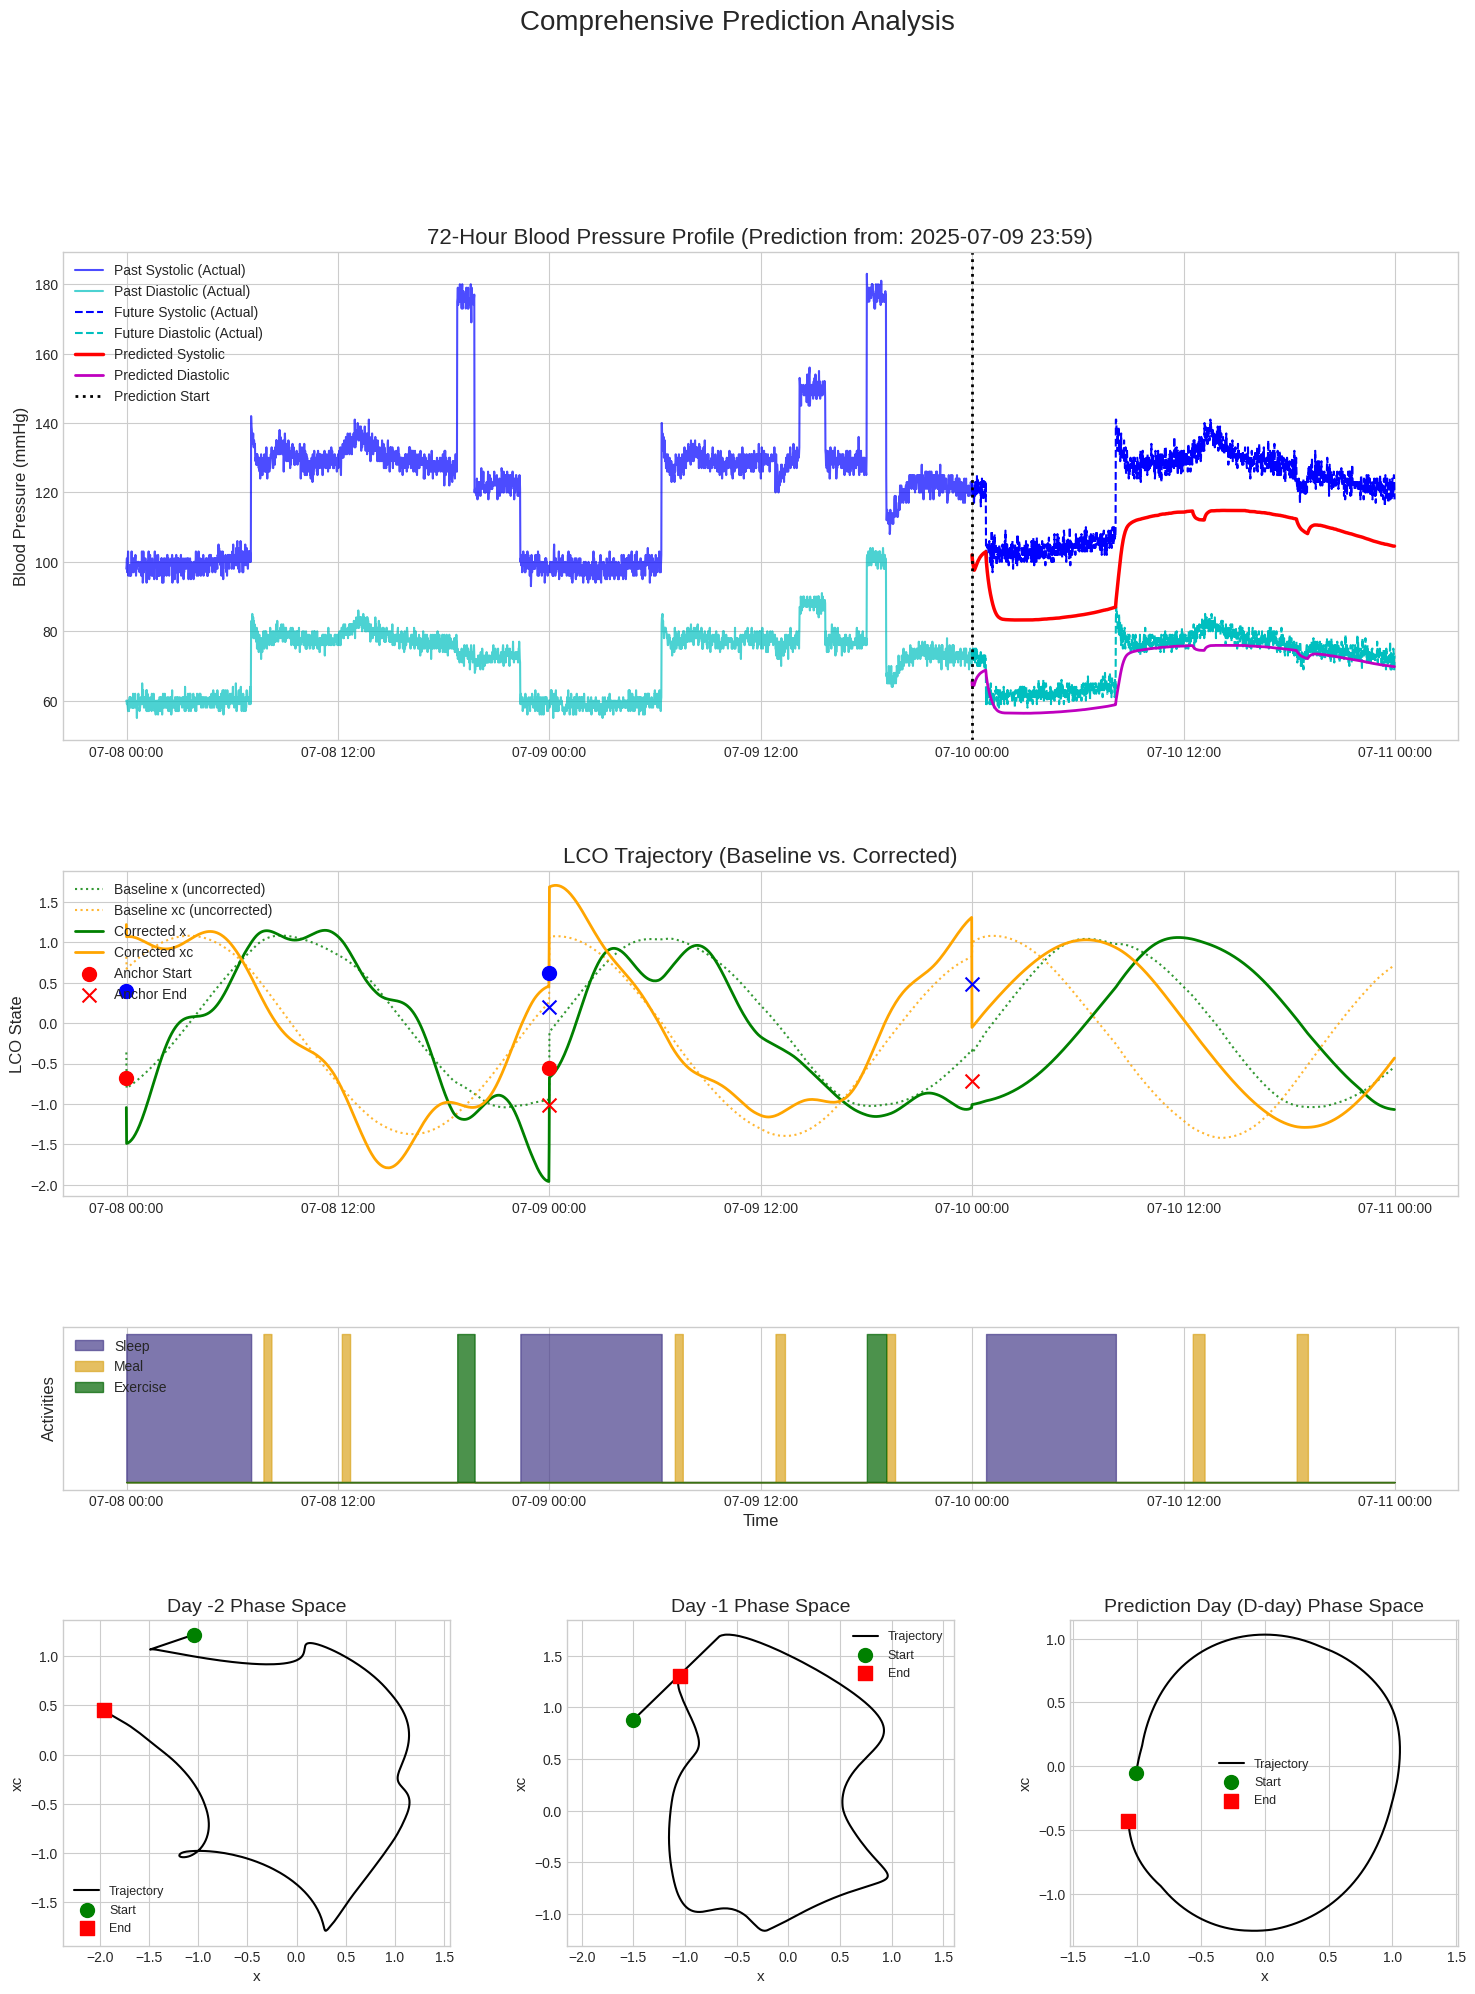


프로그램 실행이 완료되었습니다.


In [9]:
# =============================================================================
# 9. 메인 실행 블록
# =============================================================================
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="실시간 혈압 예측 AI v0.22.2")
    parser.add_argument('--mode', type=str, default='train', choices=['train', 'predict', 'train_only'],
                        help="실행 모드: 'train' (전체), 'train_only' (학습만), 'predict' (예측 데모)")

    import sys
    if 'ipykernel' in sys.modules:
        # Colab/Jupyter 환경일 경우, 여기서 모드 지정.
        args = parser.parse_args(['--mode', 'predict'])
    else:
        # 커맨드 라인 환경일 경우, 기존 방식.
        args = parser.parse_args()

    config = {
        'batch_size': BATCH_SIZE, 'input_seq_len': INPUT_SEQUENCE_LENGTH,
        'prediction_horizon': PREDICTION_HORIZON, 'num_bp_features': NUM_BP_FEATURES,
        'lookback_days': PHASE_CORRECTION_LOOKBACK_DAYS, 'day_minutes': DAY_MINUTES,
        'num_markers_to_keep': NUM_MARKERS_TO_KEEP, 'lambda_reg': LAMBDA_REG,
        'lambda_cont': LAMBDA_CONT, 'lambda_anchor': LAMBDA_ANCHOR,
        'lambda_boundary': LAMBDA_BOUNDARY, 'num_layers': NUM_LAYERS,
        'd_model': D_MODEL, 'num_heads': NUM_HEADS, 'dff': DFF,
        'rate': DROPOUT_RATE, 'epochs': EPOCHS, 'learning_rate': LEARNING_RATE,
        'num_harmonics': NUM_FOURIER_HARMONICS, 'lstm_units': LSTM_UNITS,
        'decoder_lstm_units': DECODER_LSTM_UNITS,
    }

    try:
        if args.mode == 'train':
            print("\n" + "="*70 + "\n  Training Mode: 전체 학습 파이프라인 실행\n" + "="*70 + "\n")
            run_training_pipeline(config)
        elif args.mode == 'train_only':
            run_training_only(config)
        elif args.mode == 'predict':
            print("\n" + "="*70 + "\n  Prediction Mode: 저장된 모델로 예측 실행\n" + "="*70 + "\n")
            run_prediction_demo(config)

    except Exception as e:
        print(f"\n치명적인 오류 발생: {e}")
        import traceback
        traceback.print_exc()

    print("\n프로그램 실행이 완료되었습니다.")